In [1]:
import json
import numpy as np
import glob
import os
import anndata

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import pandas as pd
import json

from sklearn.metrics import pairwise_distances

from scipy import optimize

import importlib

from dredFISH.Utils.__init__plots import *
from dredFISH.Utils import basicu 
from dredFISH.Utils.miscu import order_by_hc
from dredFISH.Utils import designu

# from dredFISH.Design.model_v2p2_gene_constraints import CellTypeNet
from dredFISH.Design import data_loader_scrna 

# config = importlib.import_module("dredfish_processing_config")

importlib.reload(data_loader_scrna)
importlib.reload(designu)

<module 'dredFISH.Utils.designu' from '/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Utils/designu.py'>

In [2]:
def scale_and_clip(w0, beta0, gc):
    """Scale up the w matrix by beta0, clipped by gene constraint.
    """
    assert np.abs(np.sum(w0) - 1)<1e-5 # close to 1
    assert len(gc) == len(w0)
    
    # scale
    Wn  = w0*beta0
    # integerize 
    Wni = (Wn+0.5).astype(int)
    # constraints (total counts of a gene across 24 basis has limit)
    cnstrnts_scale = np.clip(Wni.sum(axis=1)/gc, 1, None) #.values # at least 1; maybe >1 
    Wnic = Wni/cnstrnts_scale.reshape(-1,1)
    Wnic = Wnic.astype(int) #.fillna(0).astype(int) # NaN means cnstrnts == 0
    
    return Wn, Wni, Wnic

def proc_pmat(pmat, ftrs_all, genes_idx, clsts, _drows=None):
    """
    """
    prx = torch.from_numpy(pmat.values).float()
    
    ftrs = basicu.libsize_norm(ftrs_all, scale=1e6)
    ftrs = ftrs[:,genes_idx] 
    prjx = ftrs.mm(prx)
    prjx = prjx.numpy()
    embx = prjx
    print(prjx.shape, embx.shape, clsts.shape)

    nzero_prbe_cond = pmat.sum(axis=1) > 0
    pospmat = pmat[nzero_prbe_cond]
    fpmat = pospmat.divide(pospmat.sum(axis=0), axis=1)
    print(pospmat.shape, fpmat.shape)

    prjx_clsts, _ = basicu.group_mean(prjx, clsts)
    embx_clsts, _ = basicu.group_mean(embx, clsts)
    embx_clsts_z  = basicu.zscore(embx_clsts, allow_nan=True, axis=0)
    embx_clsts_corr = np.corrcoef(embx_clsts_z)

    # order by HC
    _rows = order_by_hc(embx_clsts)
    _cols = order_by_hc(embx_clsts.T)
    
    # order to emphasize diagonal elements (columns) (take quite long)
    _, _, _dcols = basicu.diag_matrix_cols(embx_clsts_z[_drows,:]) # this takes quite long
    
    return fpmat, prjx, prjx_clsts, embx_clsts, embx_clsts_z, embx_clsts_corr, _rows, _cols, _dcols

In [3]:
def calc_err(x, w, rhos=None):
    """
    X: (p, n)
    w: (p, k)
    """
    xhat = w.dot(w.T.dot(x))
    if rhos is None:
        return np.linalg.norm(x-xhat, ord='fro')**2
    else:
        return [np.linalg.norm(x-rho*xhat, ord='fro')**2 for rho in rhos]

def calc_ss(x):
    """
    X: (p, n)
    """
    xmean = np.mean(x, axis=1)
    xcentered = x-xmean.reshape(-1,1)
    return (np.linalg.norm(xcentered, ord='fro')**2)

def calc_r2(x, w):
    """
    X: (p, n)
    w: (p, k)
    """
    return 1 - calc_err(x, w)/calc_ss(x)

In [4]:
def cost_reduced(beta0, X, y, lmd, return_separate=False):
    """
    """
    diff = np.sum(beta0*X, axis=1)-y # 
    term1 = np.linalg.norm(np.maximum( diff,0), 2)**2 # penalty on diff > 0
    term2 = np.linalg.norm(np.maximum(-diff,0), 2)**2 # penalty on diff < 0
    if return_separate:
        return term1 + lmd*term2, term1, lmd*term2
    else:
        return term1 + lmd*term2
    
def cost_reduced_l1(beta0, X, y, lmd, return_separate=False):
    """
    """
    diff = np.sum(beta0*X, axis=1)-y # 
    term1 = np.linalg.norm(np.maximum( diff,0), 1) # penalty on diff > 0
    term2 = np.linalg.norm(np.maximum(-diff,0), 1) # penalty on diff < 0
    if return_separate:
        return term1 + lmd*term2, term1, lmd*term2
    else:
        return term1 + lmd*term2

In [5]:
device = torch.device('cpu')
torch.manual_seed(0) # reproduciability

In [6]:
# the dataset
trn_dataloader = data_loader_scrna.load_Allen_data(
    datasetkey='smrt_trn', 
    keyX='counts', keyY='l3_code', keyYcat='l3_cat', 
    batch_size=64,
)
tst_dataloader = data_loader_scrna.load_Allen_data(
    datasetkey='smrt_tst', 
    keyX='counts', keyY='l3_code', keyYcat='l3_cat', 
    batch_size=5000,
)

# constraints on the dataset
f = os.path.join('/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna', 
                                    'gidx_cnstrnts_pshop_mm10_isoflat_l30_tm37-47_tp37_filtered_Oct28_2022.pt')
cnstrnts_idx = torch.load(f)
f = os.path.join('/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna',      
                                         'cnstrnts_pshop_mm10_isoflat_l30_tm37-47_tp37_filtered_Oct28_2022.pt')
cnstrnts = torch.load(f)

# get genes used
f = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/pshop_smart_full_cpm1_genes_13k_oct13_2022.txt' 

# validation dataset
ftrs_all, clsts = next(iter(tst_dataloader))
ftrs_all = ftrs_all.float()#.numpy() # all features
ftrs = basicu.libsize_norm(ftrs_all, scale=1e6)
clsts = clsts.long().numpy()

# genes in the data
n_cat = len(trn_dataloader.dataset.Ycat) # number of clusters
n_gns = len(cnstrnts) # trn_dataloader.dataset.X.shape[1] # number of genes used 
genes_data = tst_dataloader.dataset.data['genes'][:] # All genes in data 
genes_cnst = genes_data[cnstrnts_idx] # Genes with constraints
print(genes_data.shape, genes_cnst.shape)

# genes used in modeling
newgenes = np.loadtxt(f, dtype=str)
newgene_cnstrnts = cnstrnts[basicu.get_index_from_array(genes_cnst, newgenes)].numpy()
newgenes.shape, newgene_cnstrnts.shape

(45768,) (22324,)


((13489,), (13489,))

In [7]:
# cluster annotation
clst_annots = tst_dataloader.dataset.Ycat[:]
type_orders = clst_annots[np.unique(clsts)]

# analysis metadata
meta_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/analysis_meta_Mar31.json'
with open(meta_path, 'r') as fh:
    meta = json.load(fh)
l3clst_order = np.array(meta['l3_clsts']) # get cluster order

_rows_l3clsts = basicu.get_index_from_array(type_orders, l3clst_order)
l3clst_order.shape, type_orders.shape, _rows_l3clsts

((42,),
 (42,),
 array([34, 38, 39, 41, 37, 28, 29, 11, 17, 18, 24,  6, 10,  9, 12, 13, 14,
        15, 21, 25, 23,  5, 26, 27, 22, 31, 32, 16, 19, 20, 36,  1,  2,  3,
         7,  4,  0,  8, 30, 35, 40, 33]))

In [8]:
all_ws = {}

all_pmats = {}
all_pmats_g = {}

all_genes = {}
all_genes_g = {}

all_gidxs = {}
all_gidxs_g = {}

gc = newgene_cnstrnts # 

In [9]:
# DPNMF probe set
f = "/bigstore/GeneralStorage/fangming/projects/dredfish/data/dpnmf.csv"
pmat = pd.read_csv(f, index_col=0) # [pmat_cols]
pmat = pmat[pmat.sum(axis=1)>0]
genes = pmat.index.values
print(pmat.shape, genes.shape)

# select only those existed in data
genes_comm = np.intersect1d(genes, genes_data)
genes = genes_comm
genes_idx = basicu.get_index_from_array(genes_data, genes)
pmat = pmat.loc[genes_comm]
print(pmat.shape, genes.shape, genes_idx.shape)

meth = 'DPNMF orig'
all_ws[meth] = ''
all_pmats[meth] = pmat
all_genes[meth] = genes
all_gidxs[meth] = genes_idx

all_pmats_g[meth] = pmat
all_genes_g[meth] = genes
all_gidxs_g[meth] = genes_idx

# extra thing
genes_orig_dpnmf_positive = genes

(5818, 24) (5818,)
(5576, 24) (5576,) (5576,)


In [10]:
# the new DPNMF design (get w0)
fs = [
    f'/bigstore/GeneralStorage/fangming/projects/dredfish/res_dpnmf/v_python/smrt_X_DPNMF_tree_oct13set_v2.h5ad', 
]

for f in fs:
    adata = anndata.read(f)
    # mus = [float(key[len('w_mu'):]) for key in adata.layers.keys()]
    # mus = [0,]
    mus = [2e4] # # 2e3] #, 5e3,]
    for mu in mus:
        label = f'w_mu{mu:.1e}'
        meth = f'DPNMF tree v2 {mu:.1e}'
        print(meth)

        w0 = adata.layers[label]

DPNMF tree v2 2.0e+04


In [11]:
gidx_w0 = basicu.get_index_from_array(genes_data, newgenes)
_X = ftrs[:,gidx_w0].T.numpy()

# optimize clipping
- minimize the number of probes clipped


In [12]:
res_all = pd.DataFrame()
res2_all = pd.DataFrame()
Np_all = []
N_all = []
beta0_all = []
for i, lmd in enumerate([0.1, 0.2, 0.5, 1]):
    resopt = optimize.minimize(cost_reduced_l1, 1e4, args=(w0/np.sum(w0), gc, lmd), bounds=[(0, None)])
    assert resopt.success
    
    beta0 = resopt.x
    Wn, Wni, Wnic = scale_and_clip(w0/np.sum(w0), beta0, gc)
    
    Np = np.sum(Wni)
    N = np.sum(Wnic)
    print(N)
    P1 = Wnic.T.dot(_X)
    P2 = Wni.T.dot(_X)

    res = basicu.corr_paired_rows_fast(P1.T, P2.T)
    res2 = basicu.corr_paired_rows_fast(P1, P2)
    
    res_all[i]  = res
    res2_all[i] = res2
    Np_all.append(Np)
    N_all.append(N)
    beta0_all.append(beta0)

2241
7526
29232
67029


/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in

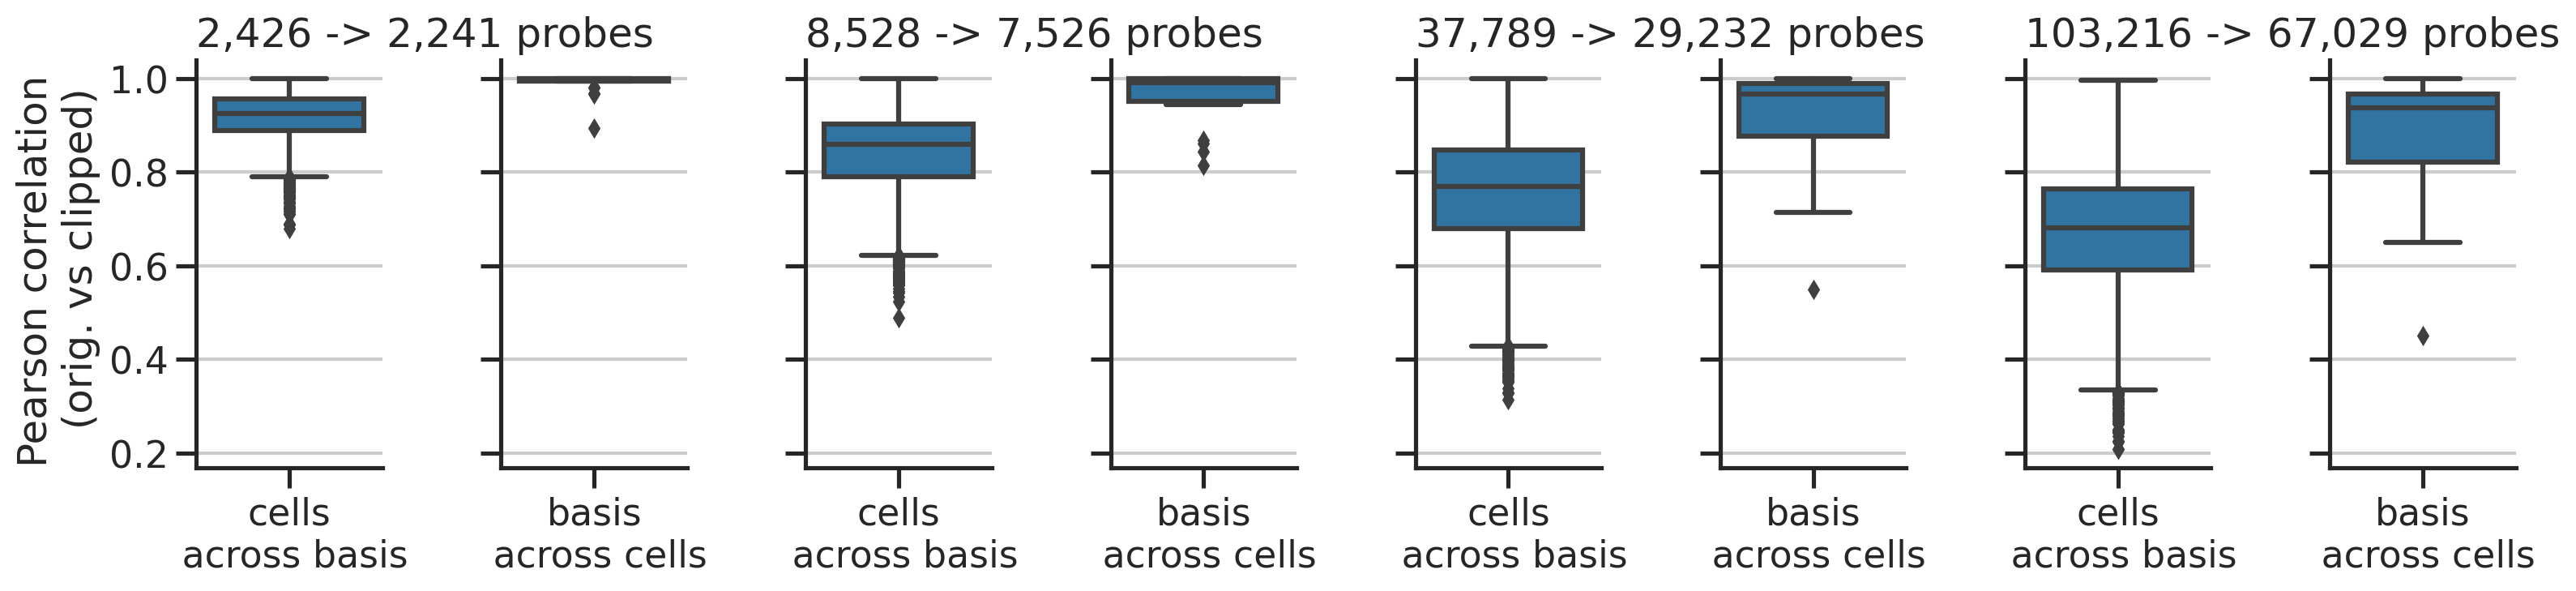

In [13]:
fig, axs = plt.subplots(1,8,figsize=(8*2,1*4), sharey=True)
for i in range(4):
    res = res_all[[i]] 
    res2 = res2_all[[i]] 
    N = N_all[i]
    Np = Np_all[i]
    
    ax = axs[2*i+0]
    ax.set_title(f'{Np:,} -> {N:,} probes', ha='left', loc='left')
    sns.boxplot(data=res.rename(columns={i: 'cells\n across basis'}), ax=ax)
    sns.despine(ax=ax)
    

    ax = axs[2*i+1]
    sns.boxplot(data=res2.rename(columns={i: 'basis\n across cells'}), ax=ax)
    sns.despine(ax=ax)
    
axs[0].set_ylabel('Pearson correlation \n (orig. vs clipped)')
fig.tight_layout()
plt.show()

In [14]:
beta0_all

[array([3576.76010987]),
 array([10000.0116406]),
 array([39280.41576005]),
 array([104453.14431688])]

In [15]:
beta0_chosen = beta0_all[2]  

In [16]:
beta0 = beta0_chosen

_, pmat, pmat_g, = scale_and_clip(w0/np.sum(w0), beta0, gc) 
pmat   = pd.DataFrame(pmat,   index=newgenes)
pmat_g = pd.DataFrame(pmat_g, index=newgenes)

pmat = pmat[pmat.sum(axis=1)>0]
genes = pmat.index.values

pmat_g = pmat_g[pmat_g.sum(axis=1)>0]
genes_g = pmat_g.index.values

# select only those existed in data
genes = np.intersect1d(genes, genes_data)
pmat = pmat.loc[genes]
genes_idx = basicu.get_index_from_array(genes_data, genes)

# select only those existed in data
genes_g = np.intersect1d(genes_g, genes_data)
pmat_g = pmat_g.loc[genes_g]
genes_idx_g = basicu.get_index_from_array(genes_data, genes_g)

all_ws[meth] = w0

all_pmats[meth] = pmat
all_pmats_g[meth] = pmat_g

all_genes[meth] = genes
all_genes_g[meth] = genes_g

all_gidxs[meth] = genes_idx
all_gidxs_g[meth] = genes_idx_g

# variance explained before and after

In [17]:
methods = all_ws.keys()
methods

dict_keys(['DPNMF orig', 'DPNMF tree v2 2.0e+04'])

In [18]:
meth = 'DPNMF tree v2 2.0e+04'

w0     = all_ws[meth] # unfiltered

pmat   = all_pmats[meth] # filtered out genes with 0 counts
gidx   = all_gidxs[meth]
pmat_g = all_pmats_g[meth]
gidx_g = all_gidxs_g[meth]

w0.shape, gidx_w0.shape, pmat.shape, gidx.shape, pmat_g.shape, gidx_g.shape, 

((13489, 24), (13489,), (7375, 24), (7375,), (7369, 24), (7369,))

In [19]:
beta0 = beta0_chosen
Wn, Wni, Wnic = scale_and_clip(w0/np.sum(w0), beta0, gc)
for w in [w0, Wn, Wni, Wnic,]: 
    w = w/np.linalg.norm(w,2)
    print(calc_r2(_X, w))

-0.5014101825122164
-0.5014101825122155
-0.5041227931475967
-0.7821632368637981


# Compare

In [20]:
def plot_intn_v2(prjx, meth, color, ax1, ax2, ylim=None):
    """
    # intensity across bits
    """
    prjx_medbits = np.median(prjx, axis=0)
    prjx_q10bits = np.percentile(prjx, 10, axis=0)
    prjx_q90bits = np.percentile(prjx, 90, axis=0)
    # prjx_q01bits = np.percentile(prjx, 1 , axis=0)
    # prjx_q99bits = np.percentile(prjx, 99, axis=0)
    order = np.argsort(prjx_medbits)[::-1]
    
    n = len(prjx_medbits)
    
    ax = ax1
    ax.plot(np.arange(n), prjx_medbits[order], '-', label=meth, color=color)
    ax.fill_between(np.arange(n), 
                    y1=prjx_q10bits[order], 
                    y2=prjx_q90bits[order], 
                    edgecolor='none',
                    alpha=0.5,
                    color=color,
                   )

    ax.set_title('10,50,90 percentiles')
    ax.set_yscale('log')
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_ylabel('Intensity')
    sns.despine(ax=ax)

    ax = ax2
    # ax.plot(np.arange(n), np.log2((prjx_q90bits[order]+1)/(prjx_q10bits[order]+1)), '-', label=meth, color=color)
    ax.plot(np.arange(n), (prjx_q90bits[order]+1)/(prjx_q10bits[order]+1), '-', label=meth, color=color)
    # ax.set_ylim(ymin=0)
    ax.set_yscale('log')
    ax.set_ylabel('FC 90%/10%')
    ax.legend(bbox_to_anchor=(1,1))
    sns.despine(ax=ax)
    ax.set_ylim(ymax=100)
    # ax.set_xticks(np.arange(n)) 
    # ax.set_xticklabels(order, rotation=90)
    return

def plot_enc_v2(pmat, fpmat, pmat_g, fpmat_g, title=""):
    """
    """
    pm = sns.color_palette('husl', n_colors=pmat.shape[1])
    
    with sns.axes_style('ticks'):
        fig = plt.figure(figsize=(15*2,6))
        ax_dict = fig.subplot_mosaic("AACBBBGDDFEEE")
        
        ax = ax_dict['A']
        _mat, _row, _col = basicu.diag_matrix_rows(fpmat.values)
        nmat = len(_mat)
        sns.heatmap(pd.DataFrame(_mat, columns=_col), 
                    xticklabels=5, 
                    cmap='rocket_r',
                    ax=ax, 
                    vmax=0.01, 
                    cbar_kws=dict(shrink=0.3, label='Weight prop.', ticks=[0,0.01], aspect=10,),
                   )
        ax.set_xlabel('Basis')
        ax.set_ylabel('Genes')
        ax.set_yticks([nmat])
        ax.set_title(f"Total #: {int(np.sum(pmat.values))}")
        ax.text(0, nmat, nmat, ha='right')
        
        ax = ax_dict['B']
        for i, col in enumerate(pmat):
            _x = pmat[col]
            _x = np.flip(np.sort(_x[_x>0])) #[:,:,-1]
            ax.plot(_x, color=pm[i], label=f'{i}')
        ax.set_yscale('log')
        ax.set_xlabel('Genes')
        ax.set_ylabel('Weight')
        sns.despine(ax=ax)
        ax.set_title('Encoding matrix')
        # ax.legend(ncol=3, title='Basis')
        
        ax_dict['C'].axis('off')
        ax_dict['F'].axis('off')
        ax_dict['G'].axis('off')
        
        ax = ax_dict['D']
        _mat, _row, _col = basicu.diag_matrix_rows(fpmat_g.values)
        nmat = len(_mat)
        sns.heatmap(pd.DataFrame(_mat, columns=_col), 
                    xticklabels=5, 
                    cmap='rocket_r',
                    ax=ax, 
                    vmax=0.01, 
                    cbar_kws=dict(shrink=0.3, label='Weight prop.', ticks=[0,0.01], aspect=10,),
                   )
        ax.set_xlabel('Basis')
        ax.set_ylabel('Genes')
        ax.set_yticks([nmat])
        ax.set_title(f"Total #: {int(np.sum(pmat_g.values))}")
        ax.text(0, nmat, nmat, ha='right')
        
        ax = ax_dict['E']
        for i, col in enumerate(pmat_g):
            _x = pmat_g[col]
            _x = np.flip(np.sort(_x[_x>0])) #[:,:,-1]
            ax.plot(_x, color=pm[i], label=f'{i}')
        ax.set_yscale('log')
        ax.set_xlabel('Genes')
        ax.set_ylabel('Weight')
        sns.despine(ax=ax)
        ax.set_title('Encoding matrix')
        # ax.legend(ncol=3, title='Basis')
        
        fig.suptitle(title)
        plt.show()
    return 

def plot_embx_clsts_v2(
    prjx_clsts, embx_clsts, embx_clsts_z, 
    title1='log10(mean (Z))',
    title2='mean (Z_norm)',
    title3='bitwise zscored [mean (Z_norm)]',
    rownames=None, colnames=None, 
    _rows=None, _cols=None, 
    title='',
    figsize=(3*4,1*8)):
    """
    Projection matrix (Z)
    Embedded matrix (Z_norm)
    zscored
    
    rows, cols
    
    """
    m, n  = prjx_clsts.shape
    if rownames is None:
        rownames = np.arange(m)
    if colnames is None:
        colnames = np.arange(n)
    if _rows is None:
        _rows = np.arange(m)
    if _cols is None:
        _cols = np.arange(n)

    cbar_kws = dict(shrink=0.7, orientation='horizontal', fraction=0.02, pad=0.15)
    fig, axs = plt.subplots(1,3,figsize=figsize)
    ax = axs[0]
    _a = np.log10(prjx_clsts)
    
    sns.heatmap(_a[_rows][:,_cols], 
                yticklabels=rownames[_rows],
                xticklabels=colnames[_cols],
                cmap='coolwarm', 
                cbar_kws=cbar_kws,
                ax=ax,
               )
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_title(title1)
    ax.set_xlabel('Basis')
    ax.set_ylabel('Cell types')

    ax = axs[1]
    sns.heatmap(np.log2(10)*(_a-_a.mean(axis=0))[_rows][:,_cols], 
                yticklabels=False,
                xticklabels=colnames[_cols],
                cmap='coolwarm', 
                cbar_kws=cbar_kws,
                ax=ax,
                center=0,
                vmax= np.log2(10), 
                vmin=-np.log2(10),
               )
    ax.set_title(title2)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)

    ax = axs[2]
    zmin = np.min(embx_clsts_z)
    zmax = np.max(embx_clsts_z)
    vmin = np.clip(zmin, -3, None) 
    vmax = np.clip(zmax, None, 3) 
    sns.heatmap(embx_clsts_z[_rows][:,_cols], 
                yticklabels=False,
                xticklabels=colnames[_cols],
                cmap='coolwarm', 
                cbar_kws=cbar_kws,
                vmin=vmin,
                vmax=vmax,
                ax=ax,
               )
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
    ax.set_title(title3)
    fig.suptitle(title)
    fig.subplots_adjust(wspace=0.05)
    plt.show()

In [21]:
palette = sns.color_palette('tab10', len(all_pmats.keys()))
methods = list(all_pmats.keys())
colors = palette[:len(methods)]
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725)]

In [22]:
all_res = {}
all_res_g = {}

for meth in methods:
    pmat = all_pmats[meth]
    genes_idx = all_gidxs[meth]
    
    pmat_g = all_pmats_g[meth]
    genes_idx_g = all_gidxs_g[meth]
    
    # unclipped
    (fpmat, prjx, prjx_clsts, embx_clsts, embx_clsts_z, embx_clsts_corr, 
     _rows, _cols, _dcols) = proc_pmat(pmat, ftrs_all, genes_idx, clsts, 
                               _drows=_rows_l3clsts)
    all_res[meth] = fpmat, prjx, prjx_clsts, embx_clsts, embx_clsts_z, embx_clsts_corr, _rows, _cols, _dcols
    
    # clipped
    (fpmat, prjx, prjx_clsts, embx_clsts, embx_clsts_z, embx_clsts_corr, 
     _rows, _cols, _dcols) = proc_pmat(pmat_g, ftrs_all, genes_idx_g, clsts, 
                               _drows=_rows_l3clsts)
    all_res_g[meth] = fpmat, prjx, prjx_clsts, embx_clsts, embx_clsts_z, embx_clsts_corr, _rows, _cols, _dcols

(5000, 24) (5000, 24) (5000,)
(5576, 24) (5576, 24)
(5000, 24) (5000, 24) (5000,)
(5576, 24) (5576, 24)
(5000, 24) (5000, 24) (5000,)
(7375, 24) (7375, 24)
(5000, 24) (5000, 24) (5000,)
(7369, 24) (7369, 24)


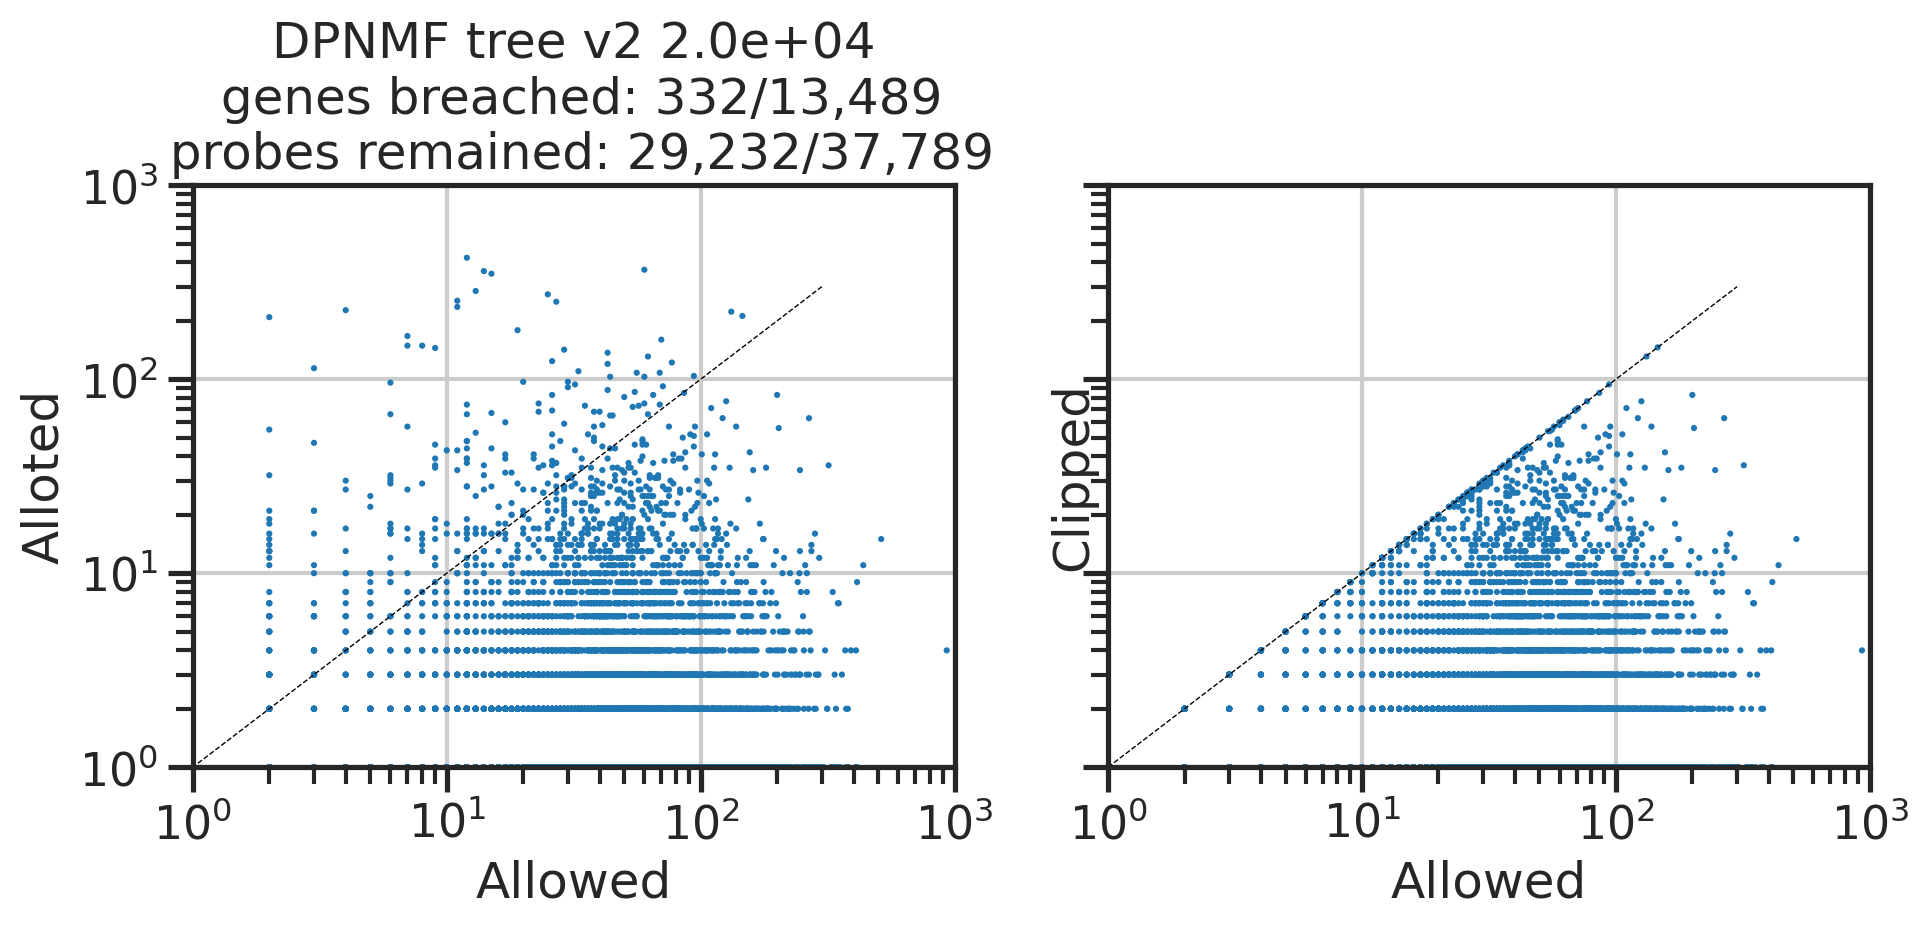

In [23]:
n = len(methods)-1
nx = 2
ny = int((n+nx-1)/nx)

fig, axs = plt.subplots(ny,nx,figsize=(nx*5,ny*5), sharex=True, sharey=True)
lbl = methods[1]
        
w = all_ws[lbl]

beta0 = beta0_chosen
Wn, Wni, Wnic = scale_and_clip(w0/np.sum(w0), beta0, gc)
alloted = Wni.sum(axis=1)
clipped = Wnic.sum(axis=1)
allowed = gc
nb = (alloted>allowed).sum()
npb = np.sum(clipped, axis=None)
        
ax = axs.flat[0]
ax.scatter(allowed, alloted, s=5, label=lbl, edgecolor='none')

ax.set_title(f'{lbl}\n genes breached: {nb}/{len(alloted):,}\n probes remained: {npb:,}/{np.sum(Wni):,}')
ax.plot([0,300], [0,300], '--k', linewidth=0.5)
ax.set_xlim([1, 1000])
ax.set_ylim([1, 1000])
ax.set_xlabel('Allowed')
ax.set_ylabel('Alloted')
ax.set_xscale('log')
ax.set_yscale('log')

ax = axs.flat[1]
ax.scatter(allowed, clipped, s=5, label=lbl, edgecolor='none')
ax.plot([0,300], [0,300], '--k', linewidth=0.5)
ax.set_xlim([1, 1000])
ax.set_ylim([1, 1000])
ax.set_xlabel('Allowed')
ax.set_ylabel('Clipped')
ax.set_xscale('log')
ax.set_yscale('log')

fig.tight_layout()
plt.show()

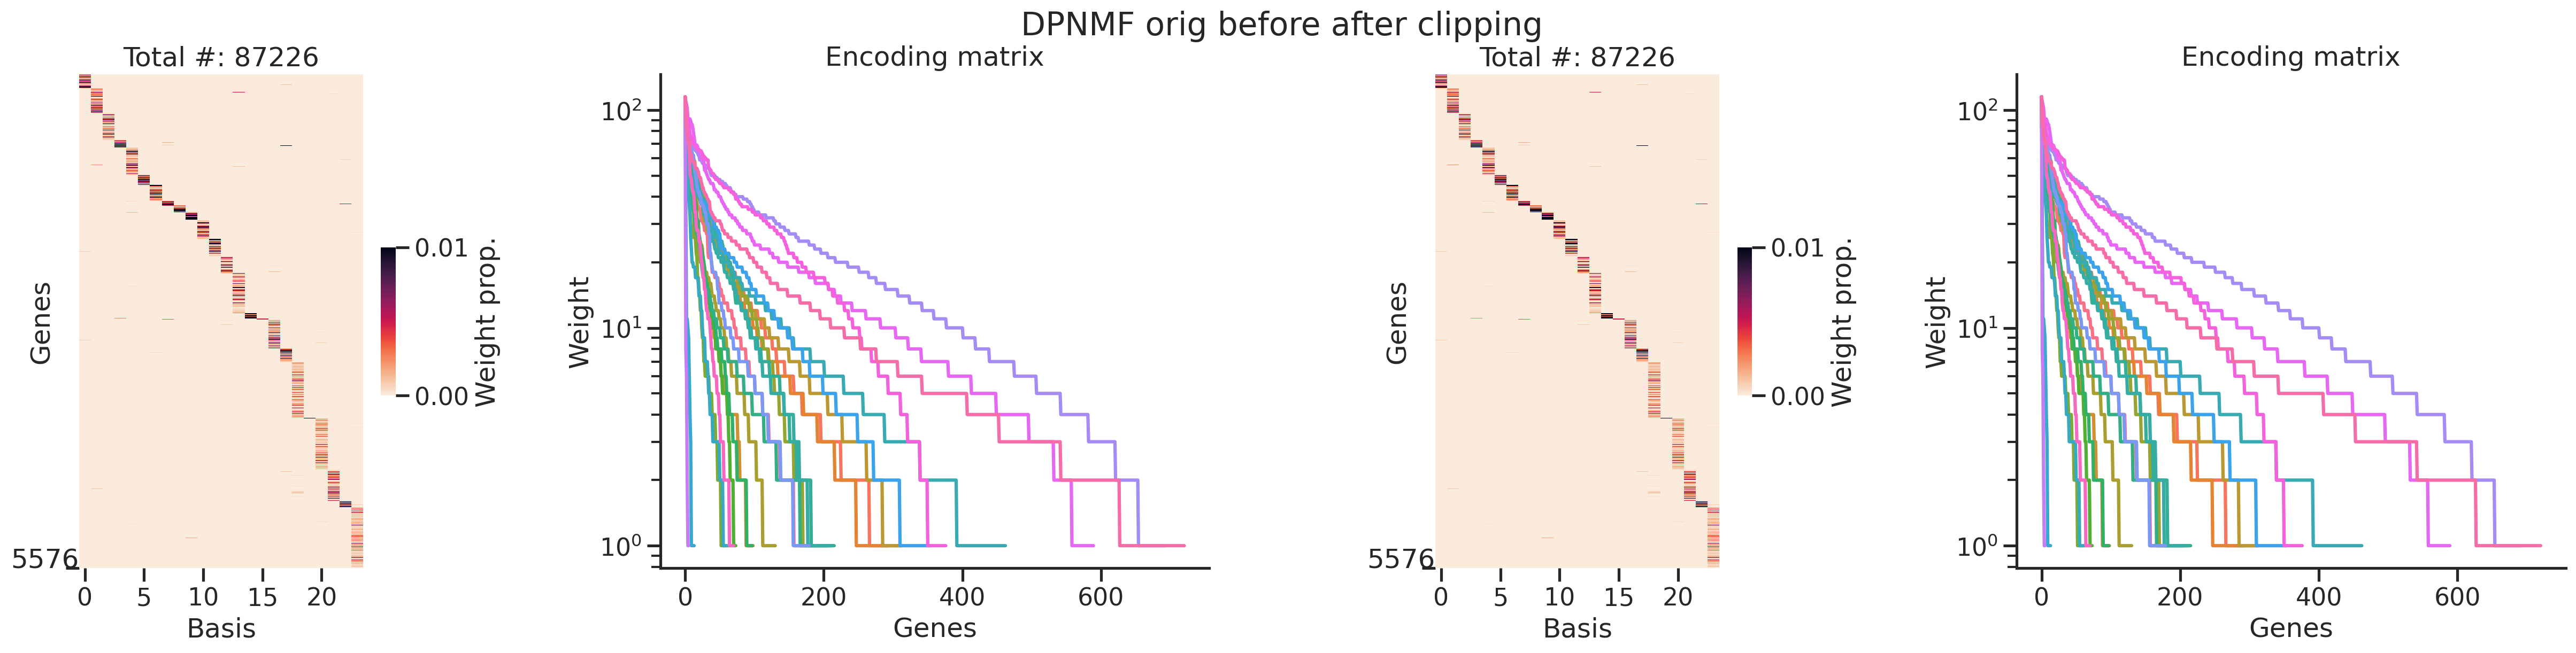

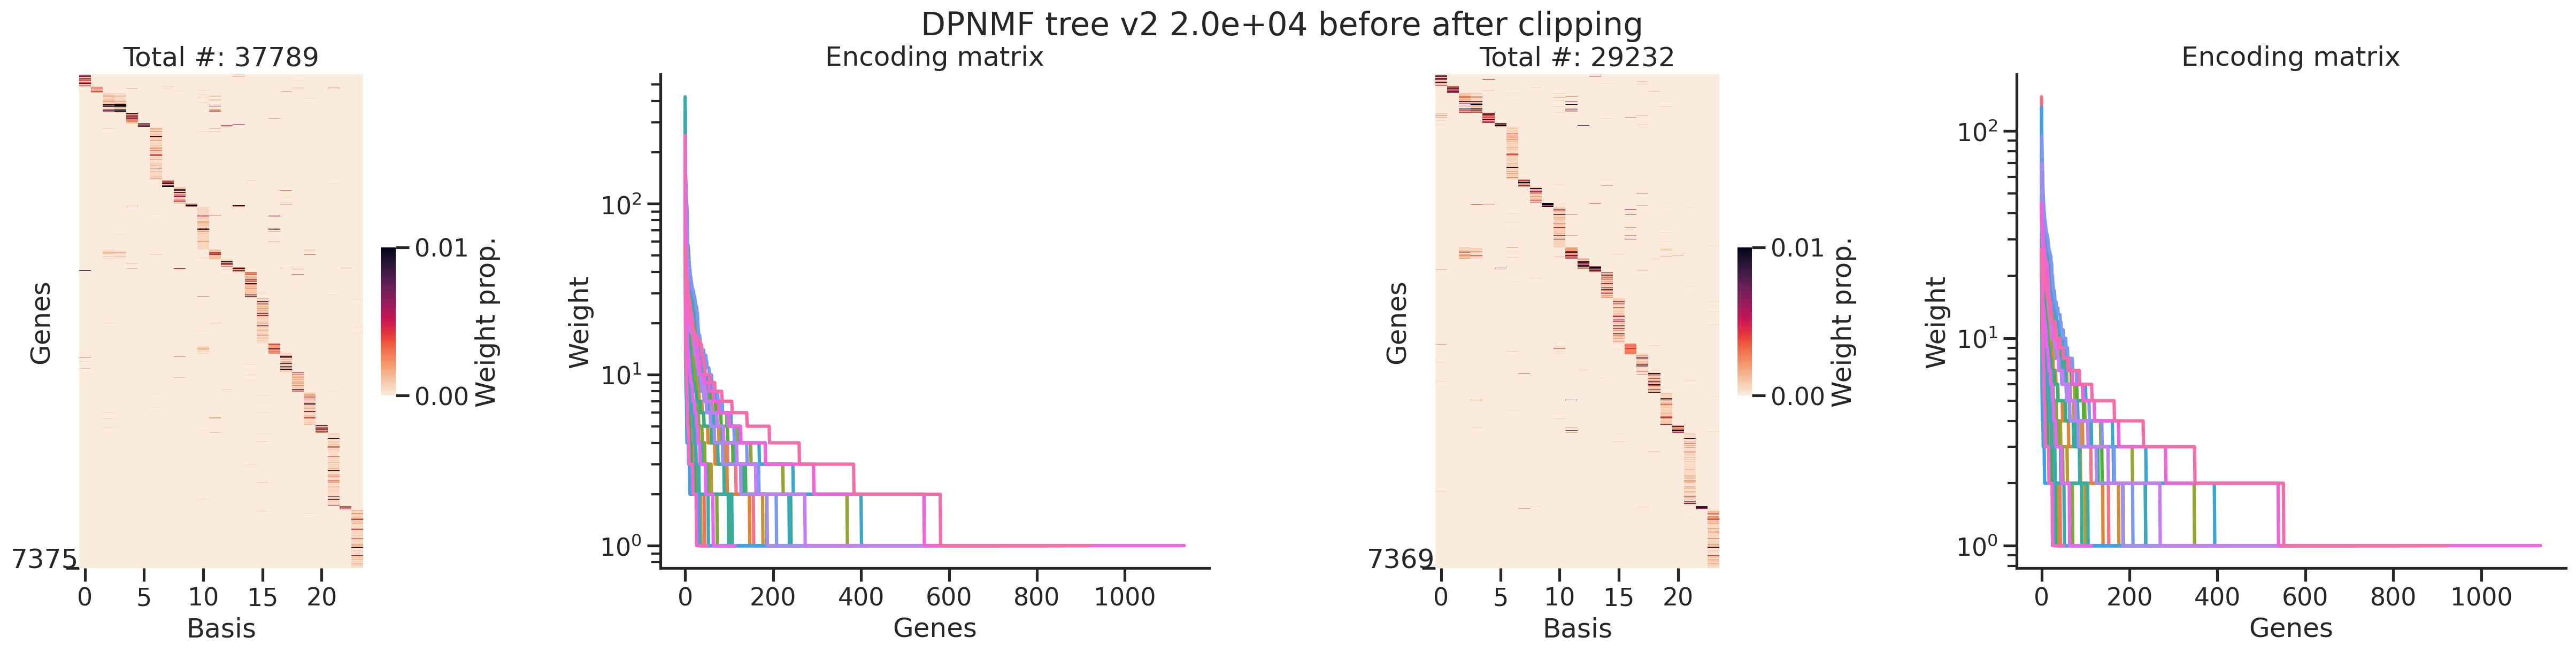

In [24]:
for meth in methods:
    pmat = all_pmats[meth]
    fpmat = all_res[meth][0]
    
    pmat_g = all_pmats_g[meth]
    fpmat_g = all_res_g[meth][0]
    
    plot_enc_v2(pmat, fpmat, pmat_g, fpmat_g, title=f"{meth} before after clipping")

DPNMF orig
DPNMF tree v2 2.0e+04
DPNMF orig
DPNMF tree v2 2.0e+04


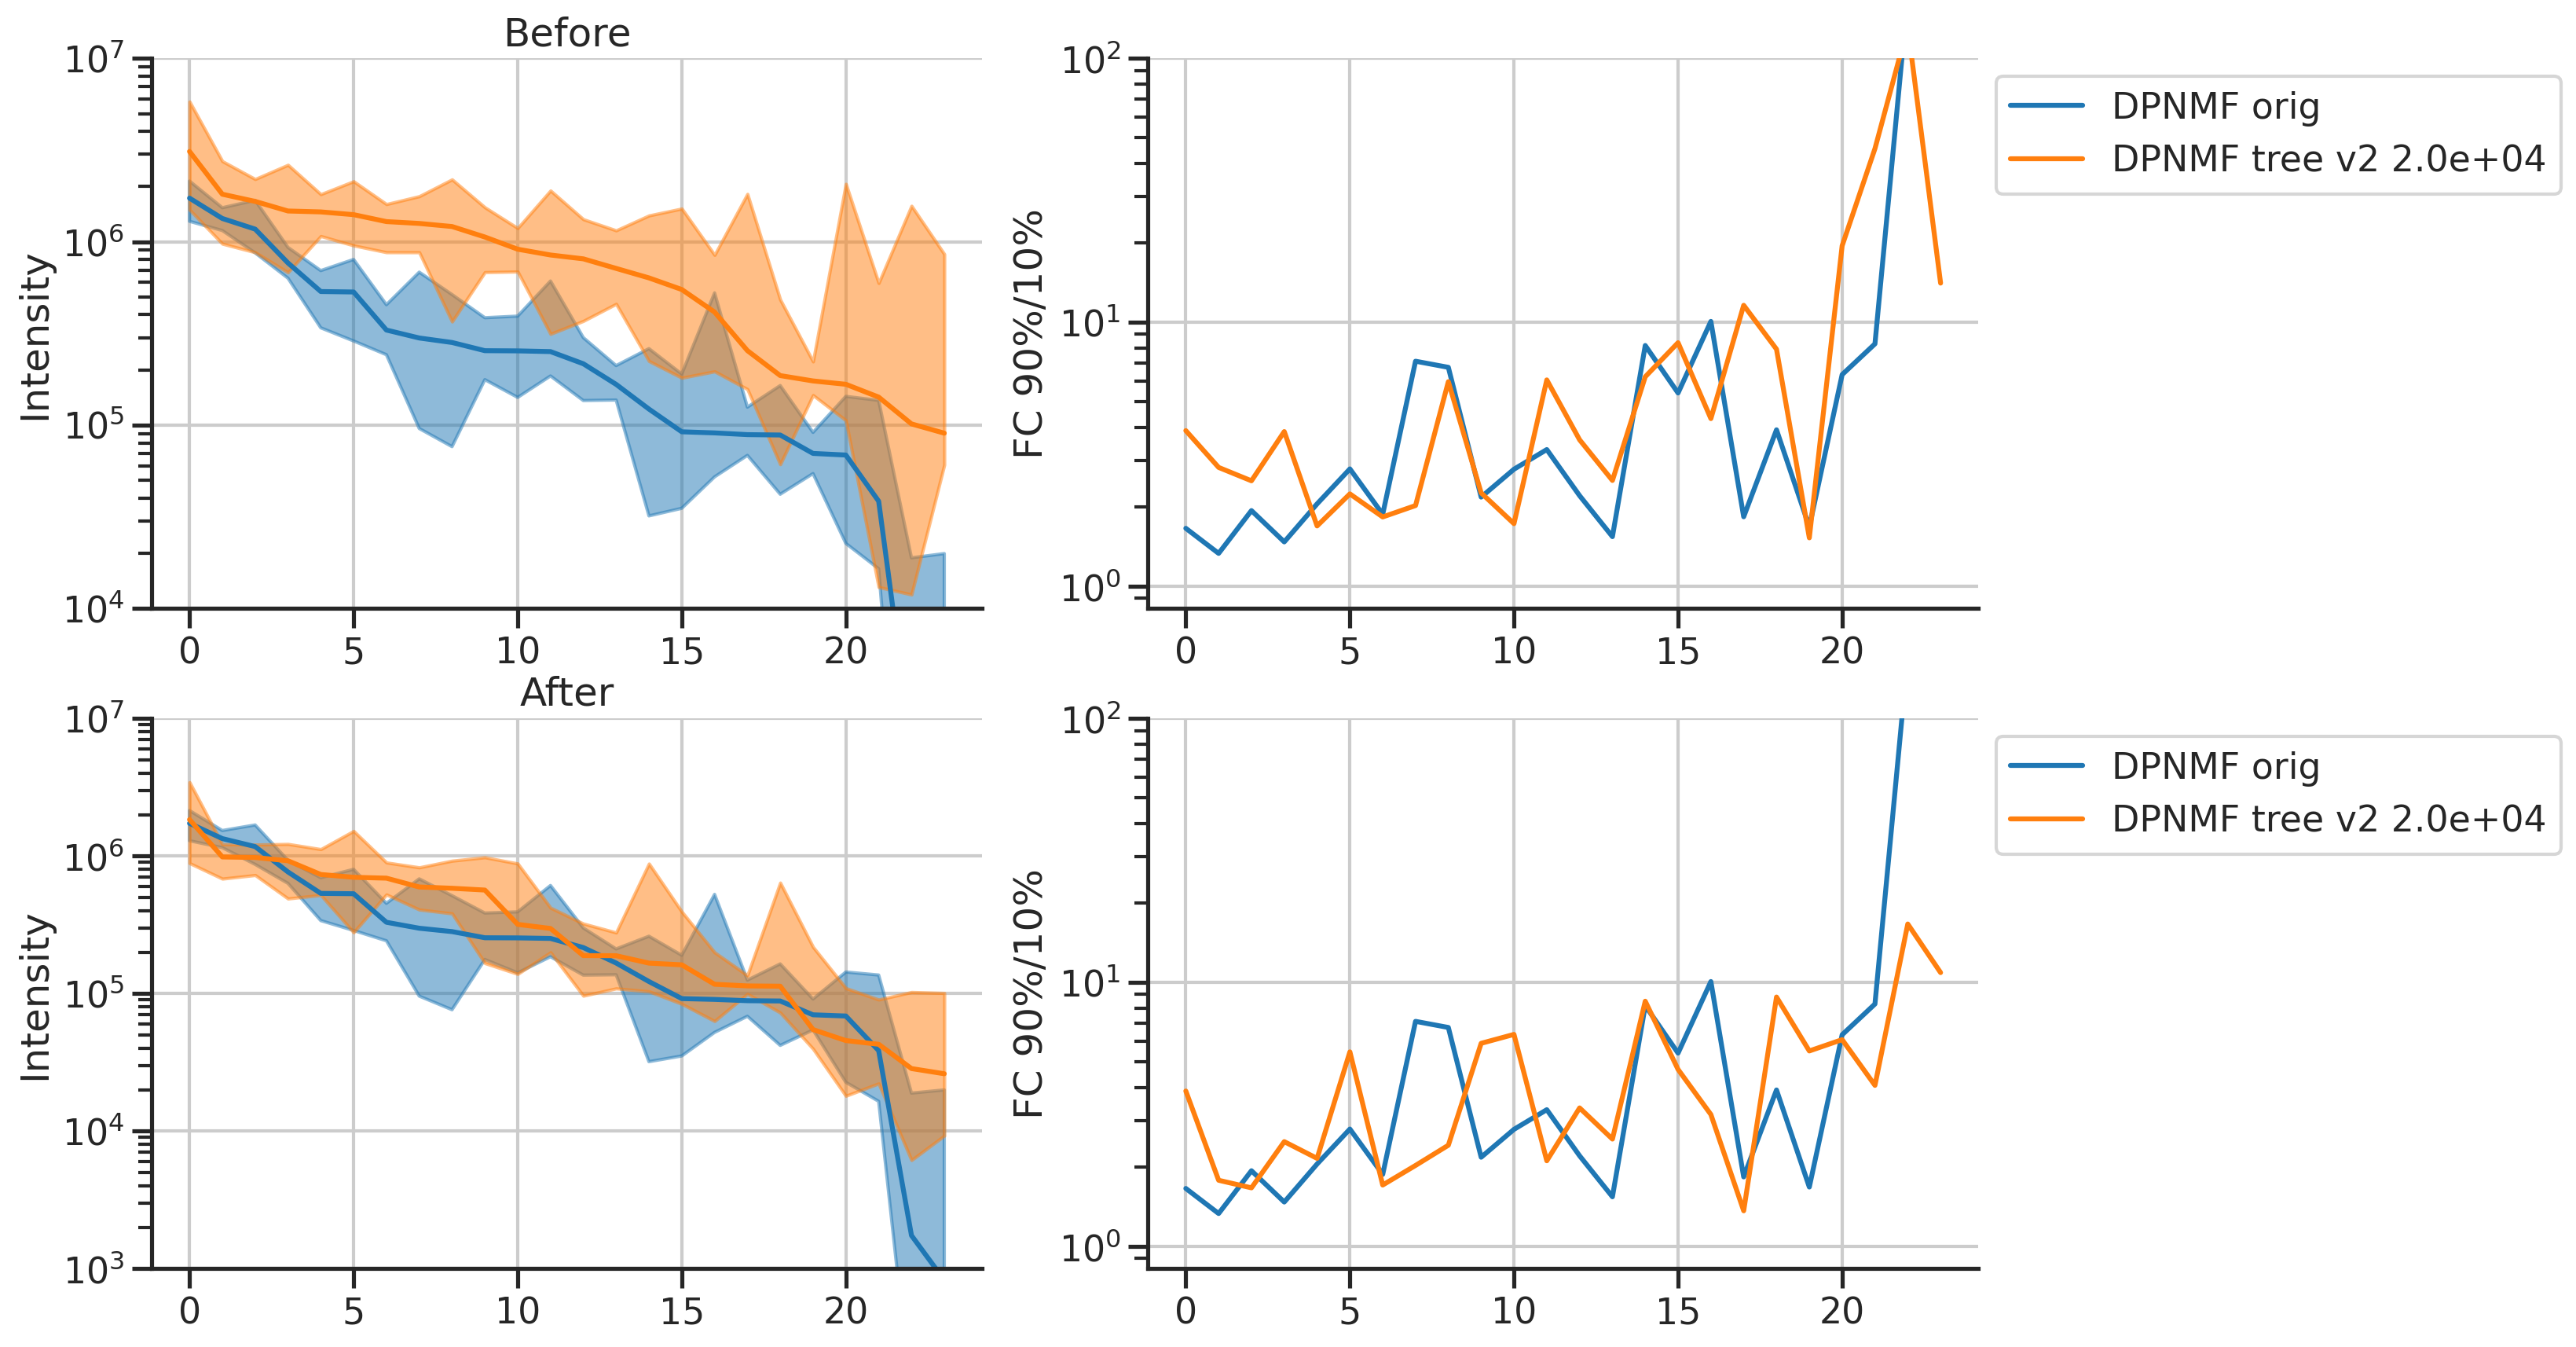

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))
ax1, ax2 = axs[0]
for i, meth in enumerate(methods):
    print(meth)
    prjx = all_res[meth][1]
    color = colors[i] # f"C{i}"
    plot_intn_v2(prjx, meth, color, ax1, ax2, ylim=[1e4, 1e7])
ax1.set_title('Before')

ax1, ax2 = axs[1]
for i, meth in enumerate(methods):
    print(meth)
    prjx = all_res_g[meth][1]
    color = colors[i] # f"C{i}"
    plot_intn_v2(prjx, meth, color, ax1, ax2, ylim=[1e3, 1e7])
ax1.set_title('After')
fig.subplots_adjust(wspace=0.2)
plt.show()

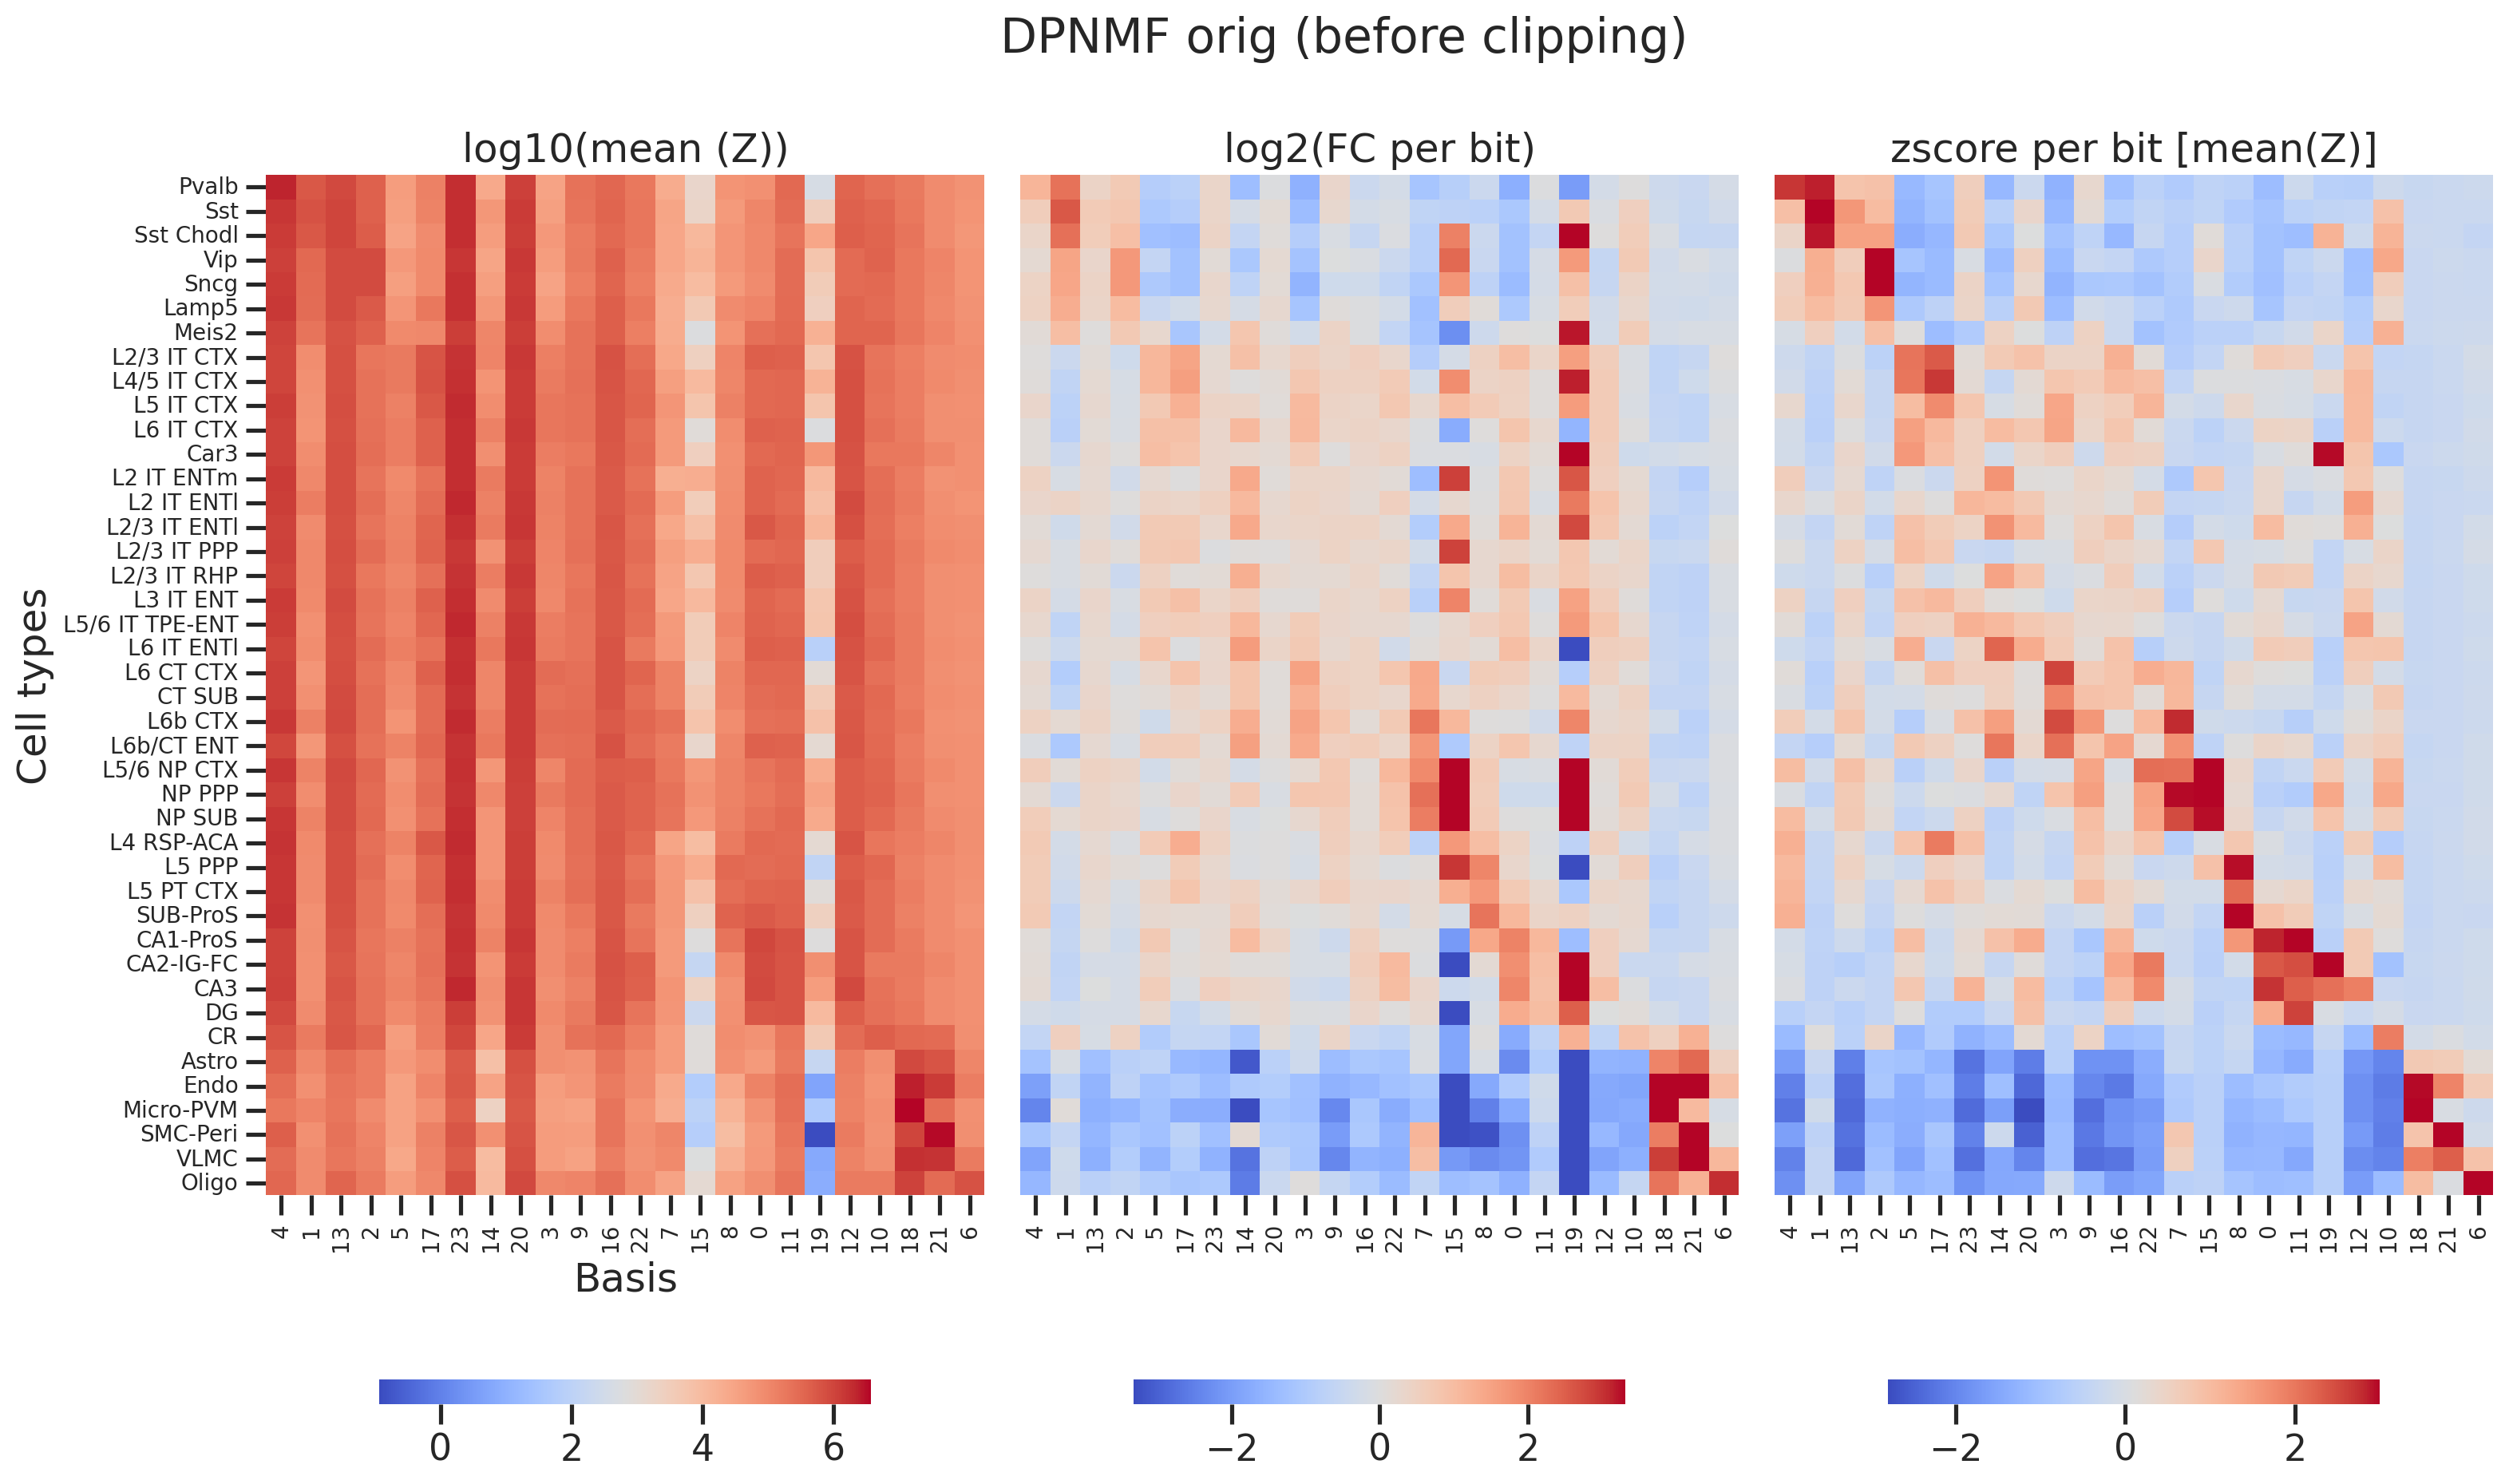

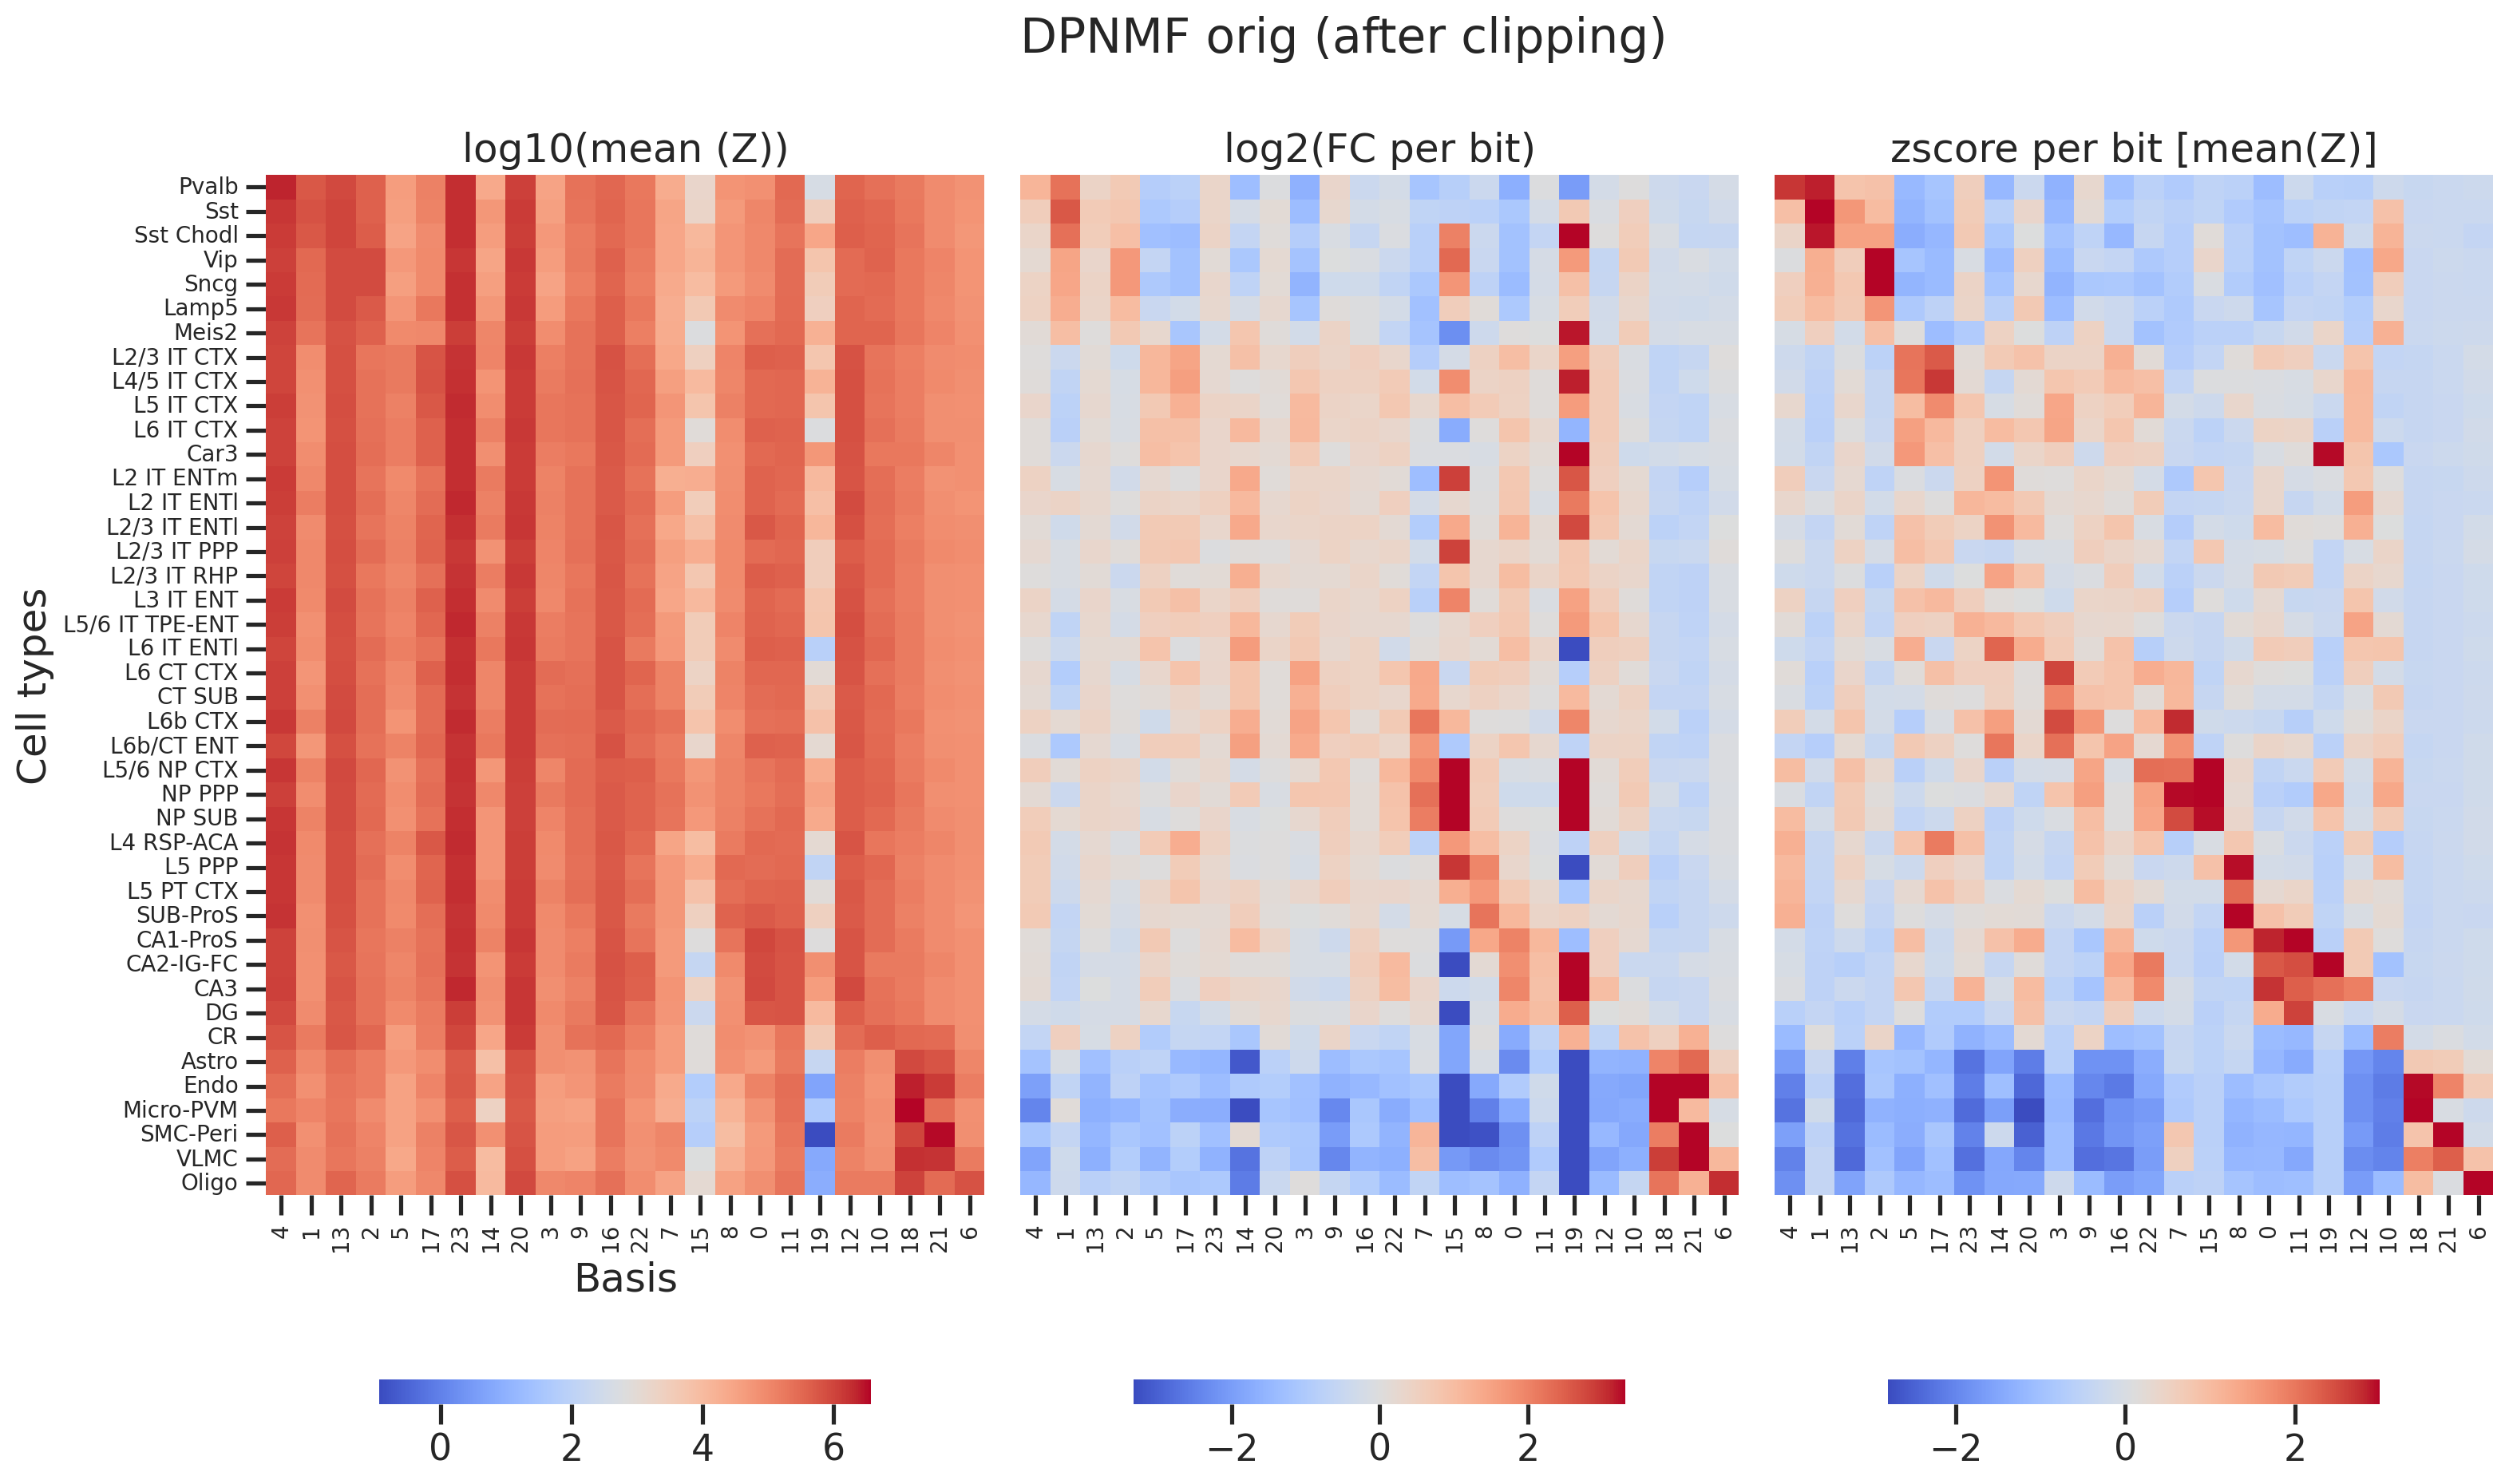

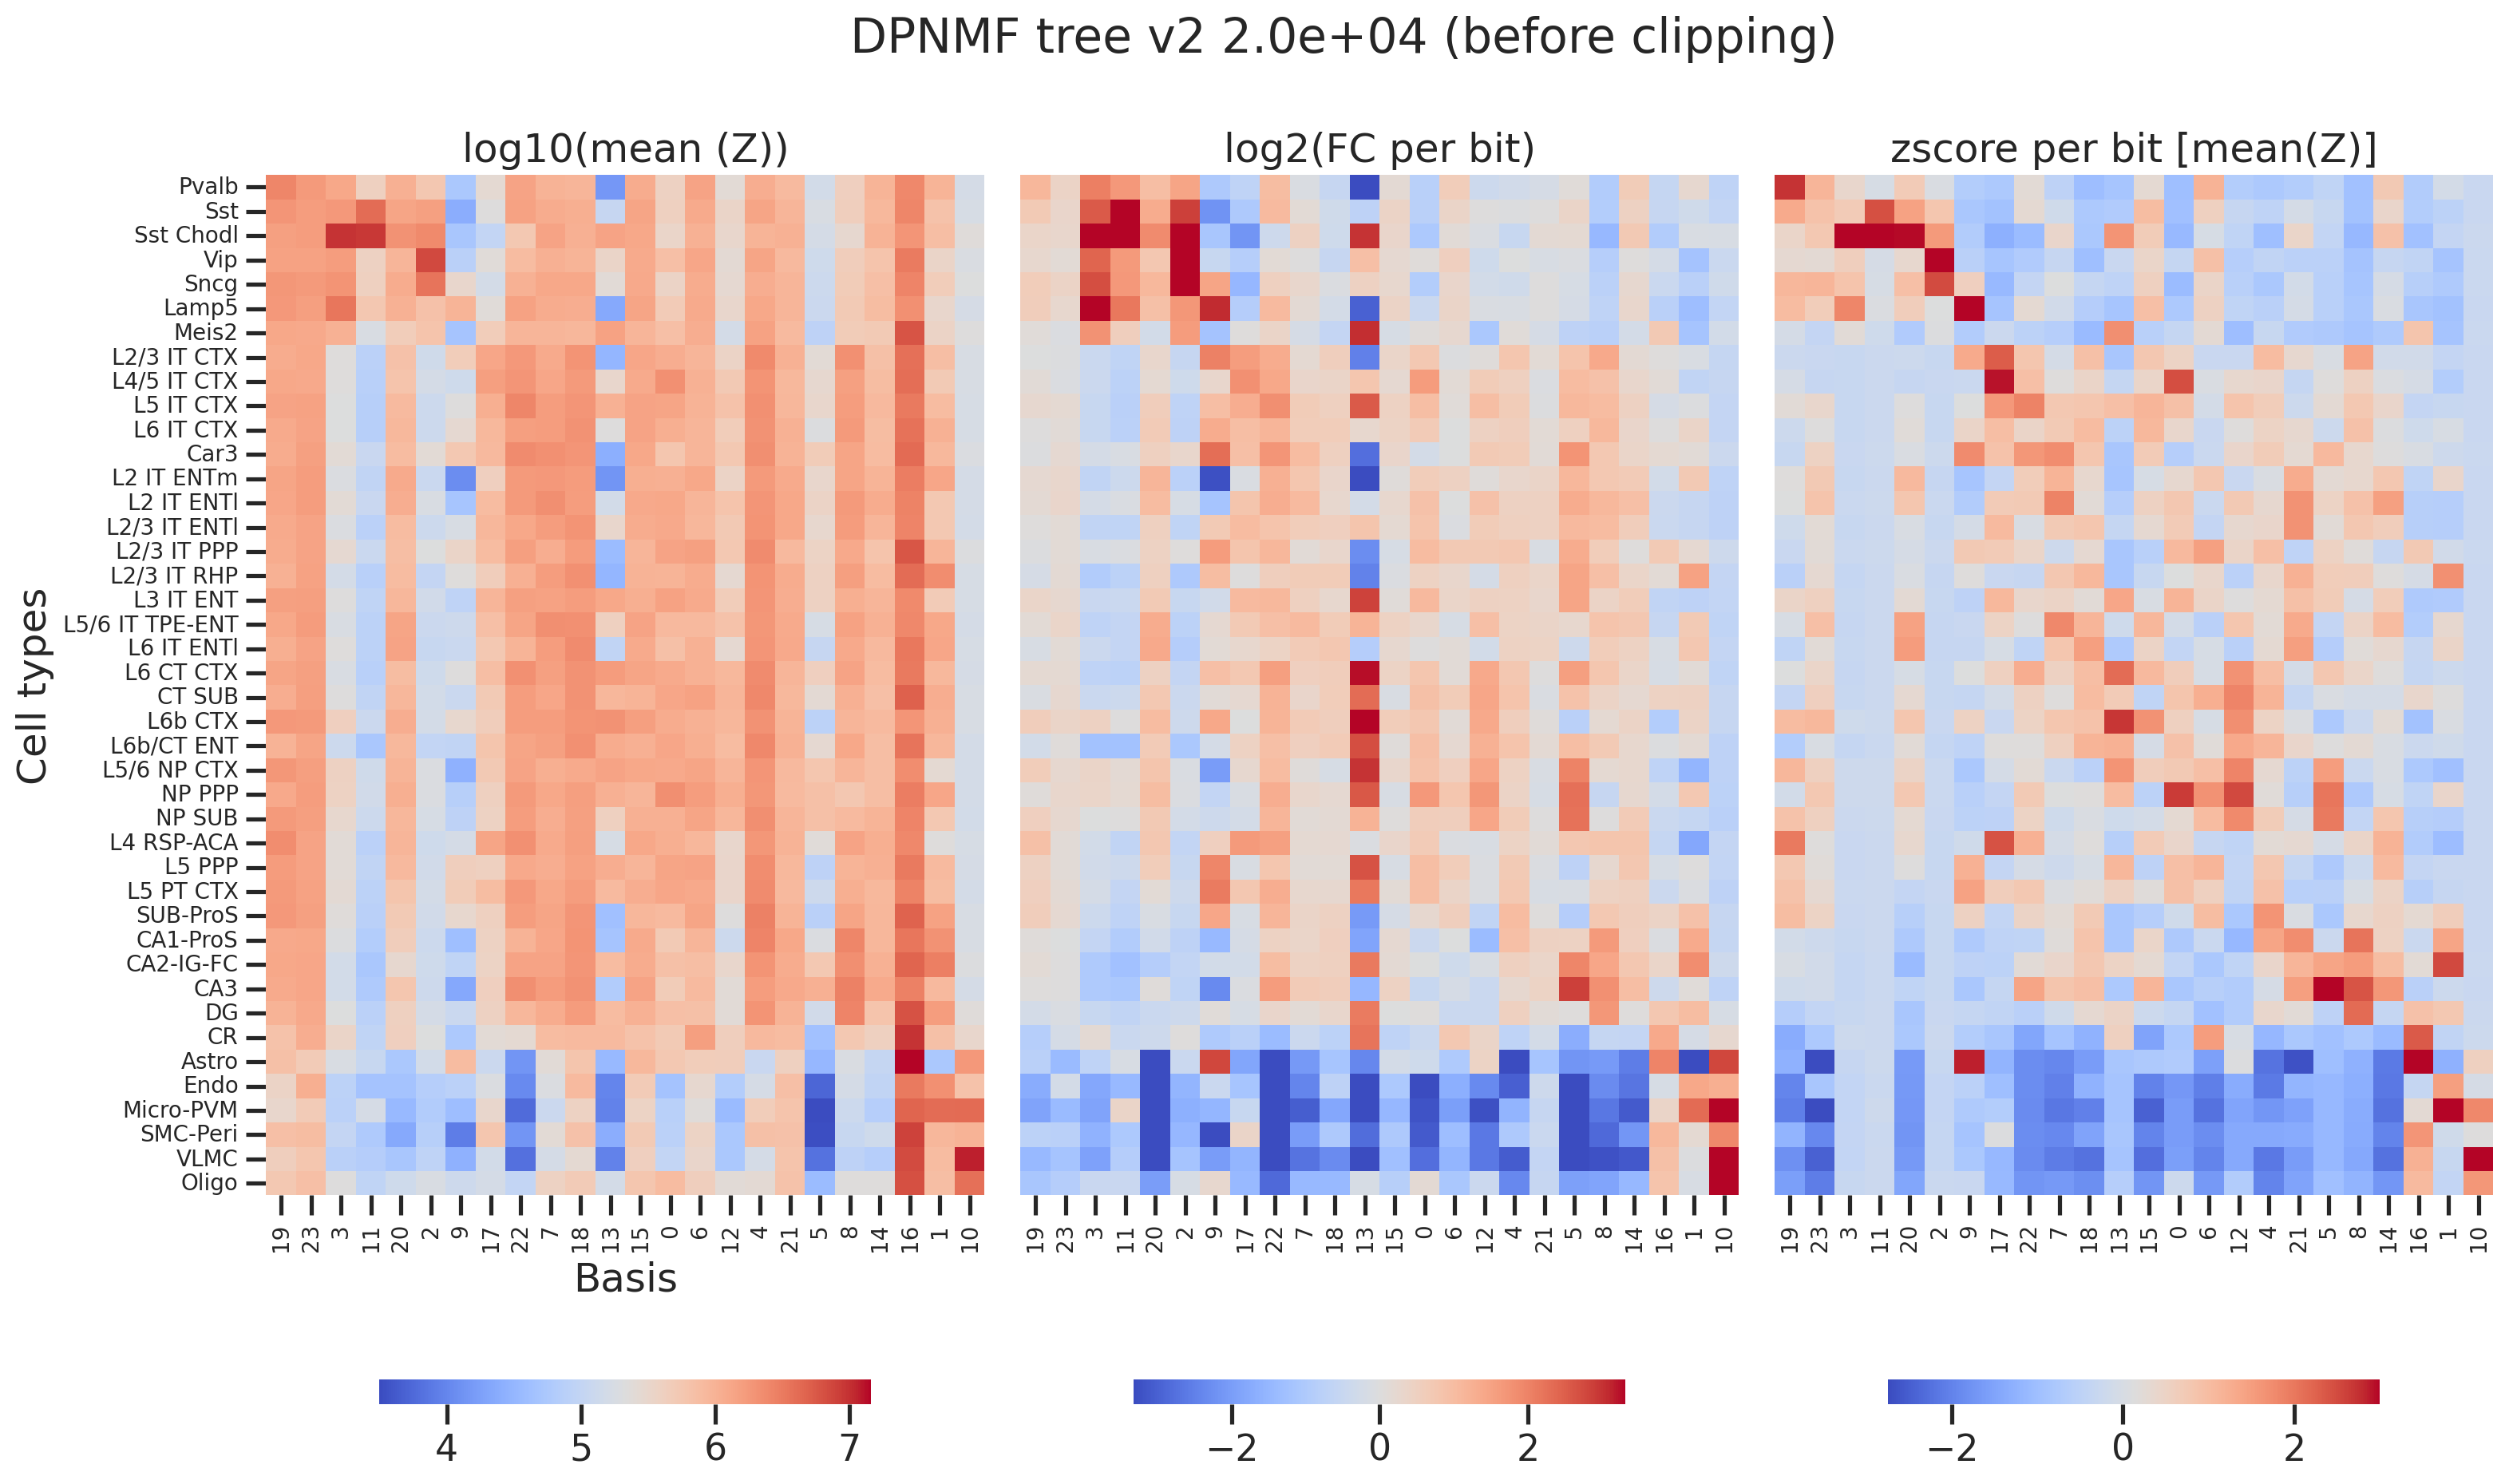

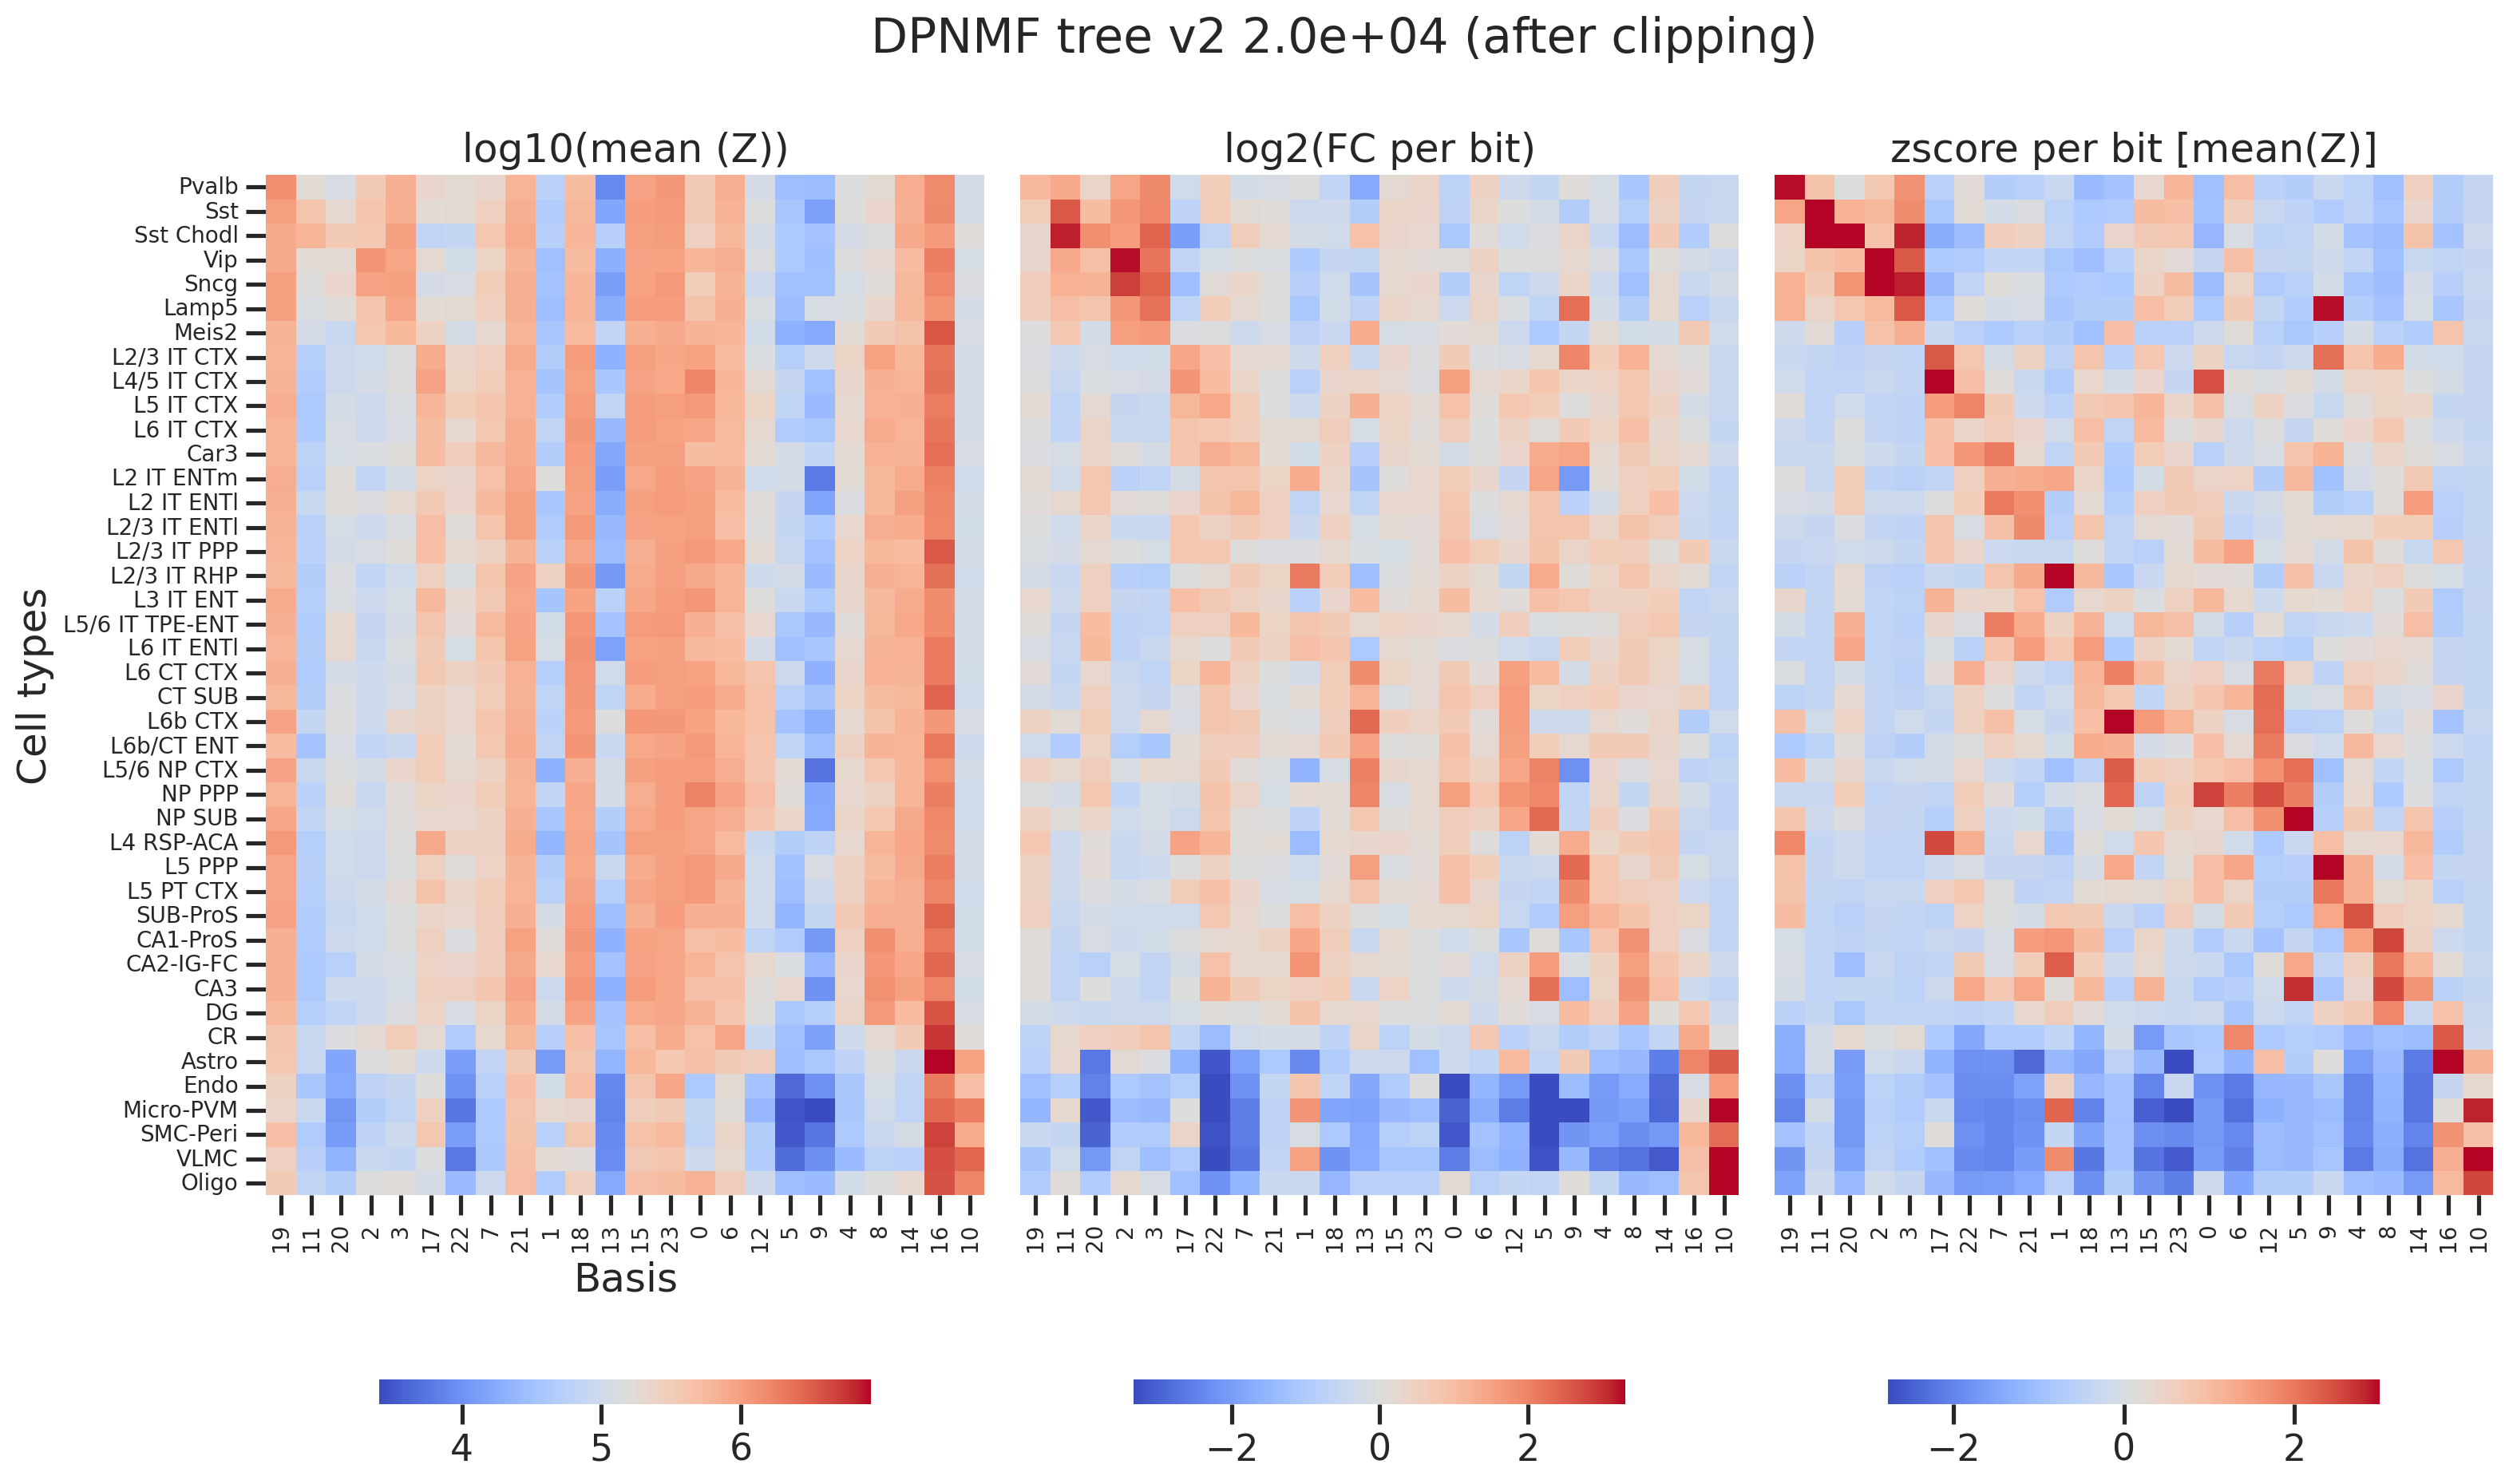

In [26]:
# diagnal ordering
for meth in methods:
    fpmat, prjx, prjx_clsts, embx_clsts, embx_clsts_z, embx_clsts_corr, _rows, _cols, _dcols, = all_res[meth] 
    plot_embx_clsts_v2(prjx_clsts, embx_clsts, embx_clsts_z, 
                            rownames=type_orders, # before rearange 
                            colnames=np.arange(24), # before rearange
                            _rows=_rows_l3clsts, # how to rearange
                            _cols=_dcols, #_dcols, #None, 
                            title=meth + " (before clipping)",
                            figsize=(3*6, 1*10),
                            title2='log2(FC per bit)',
                            title3='zscore per bit [mean(Z)]',
                           )
    
    fpmat, prjx, prjx_clsts, embx_clsts, embx_clsts_z, embx_clsts_corr, _rows, _cols, _dcols, = all_res_g[meth] 
    plot_embx_clsts_v2(prjx_clsts, embx_clsts, embx_clsts_z, 
                            rownames=type_orders, # before rearange 
                            colnames=np.arange(24), # before rearange
                            _rows=_rows_l3clsts, # how to rearange
                            _cols=_dcols, #_dcols, #None, 
                            title=meth + " (after clipping)",
                            figsize=(3*6, 1*10),
                            title2='log2(FC per bit)',
                            title3='zscore per bit [mean(Z)]',
                           )

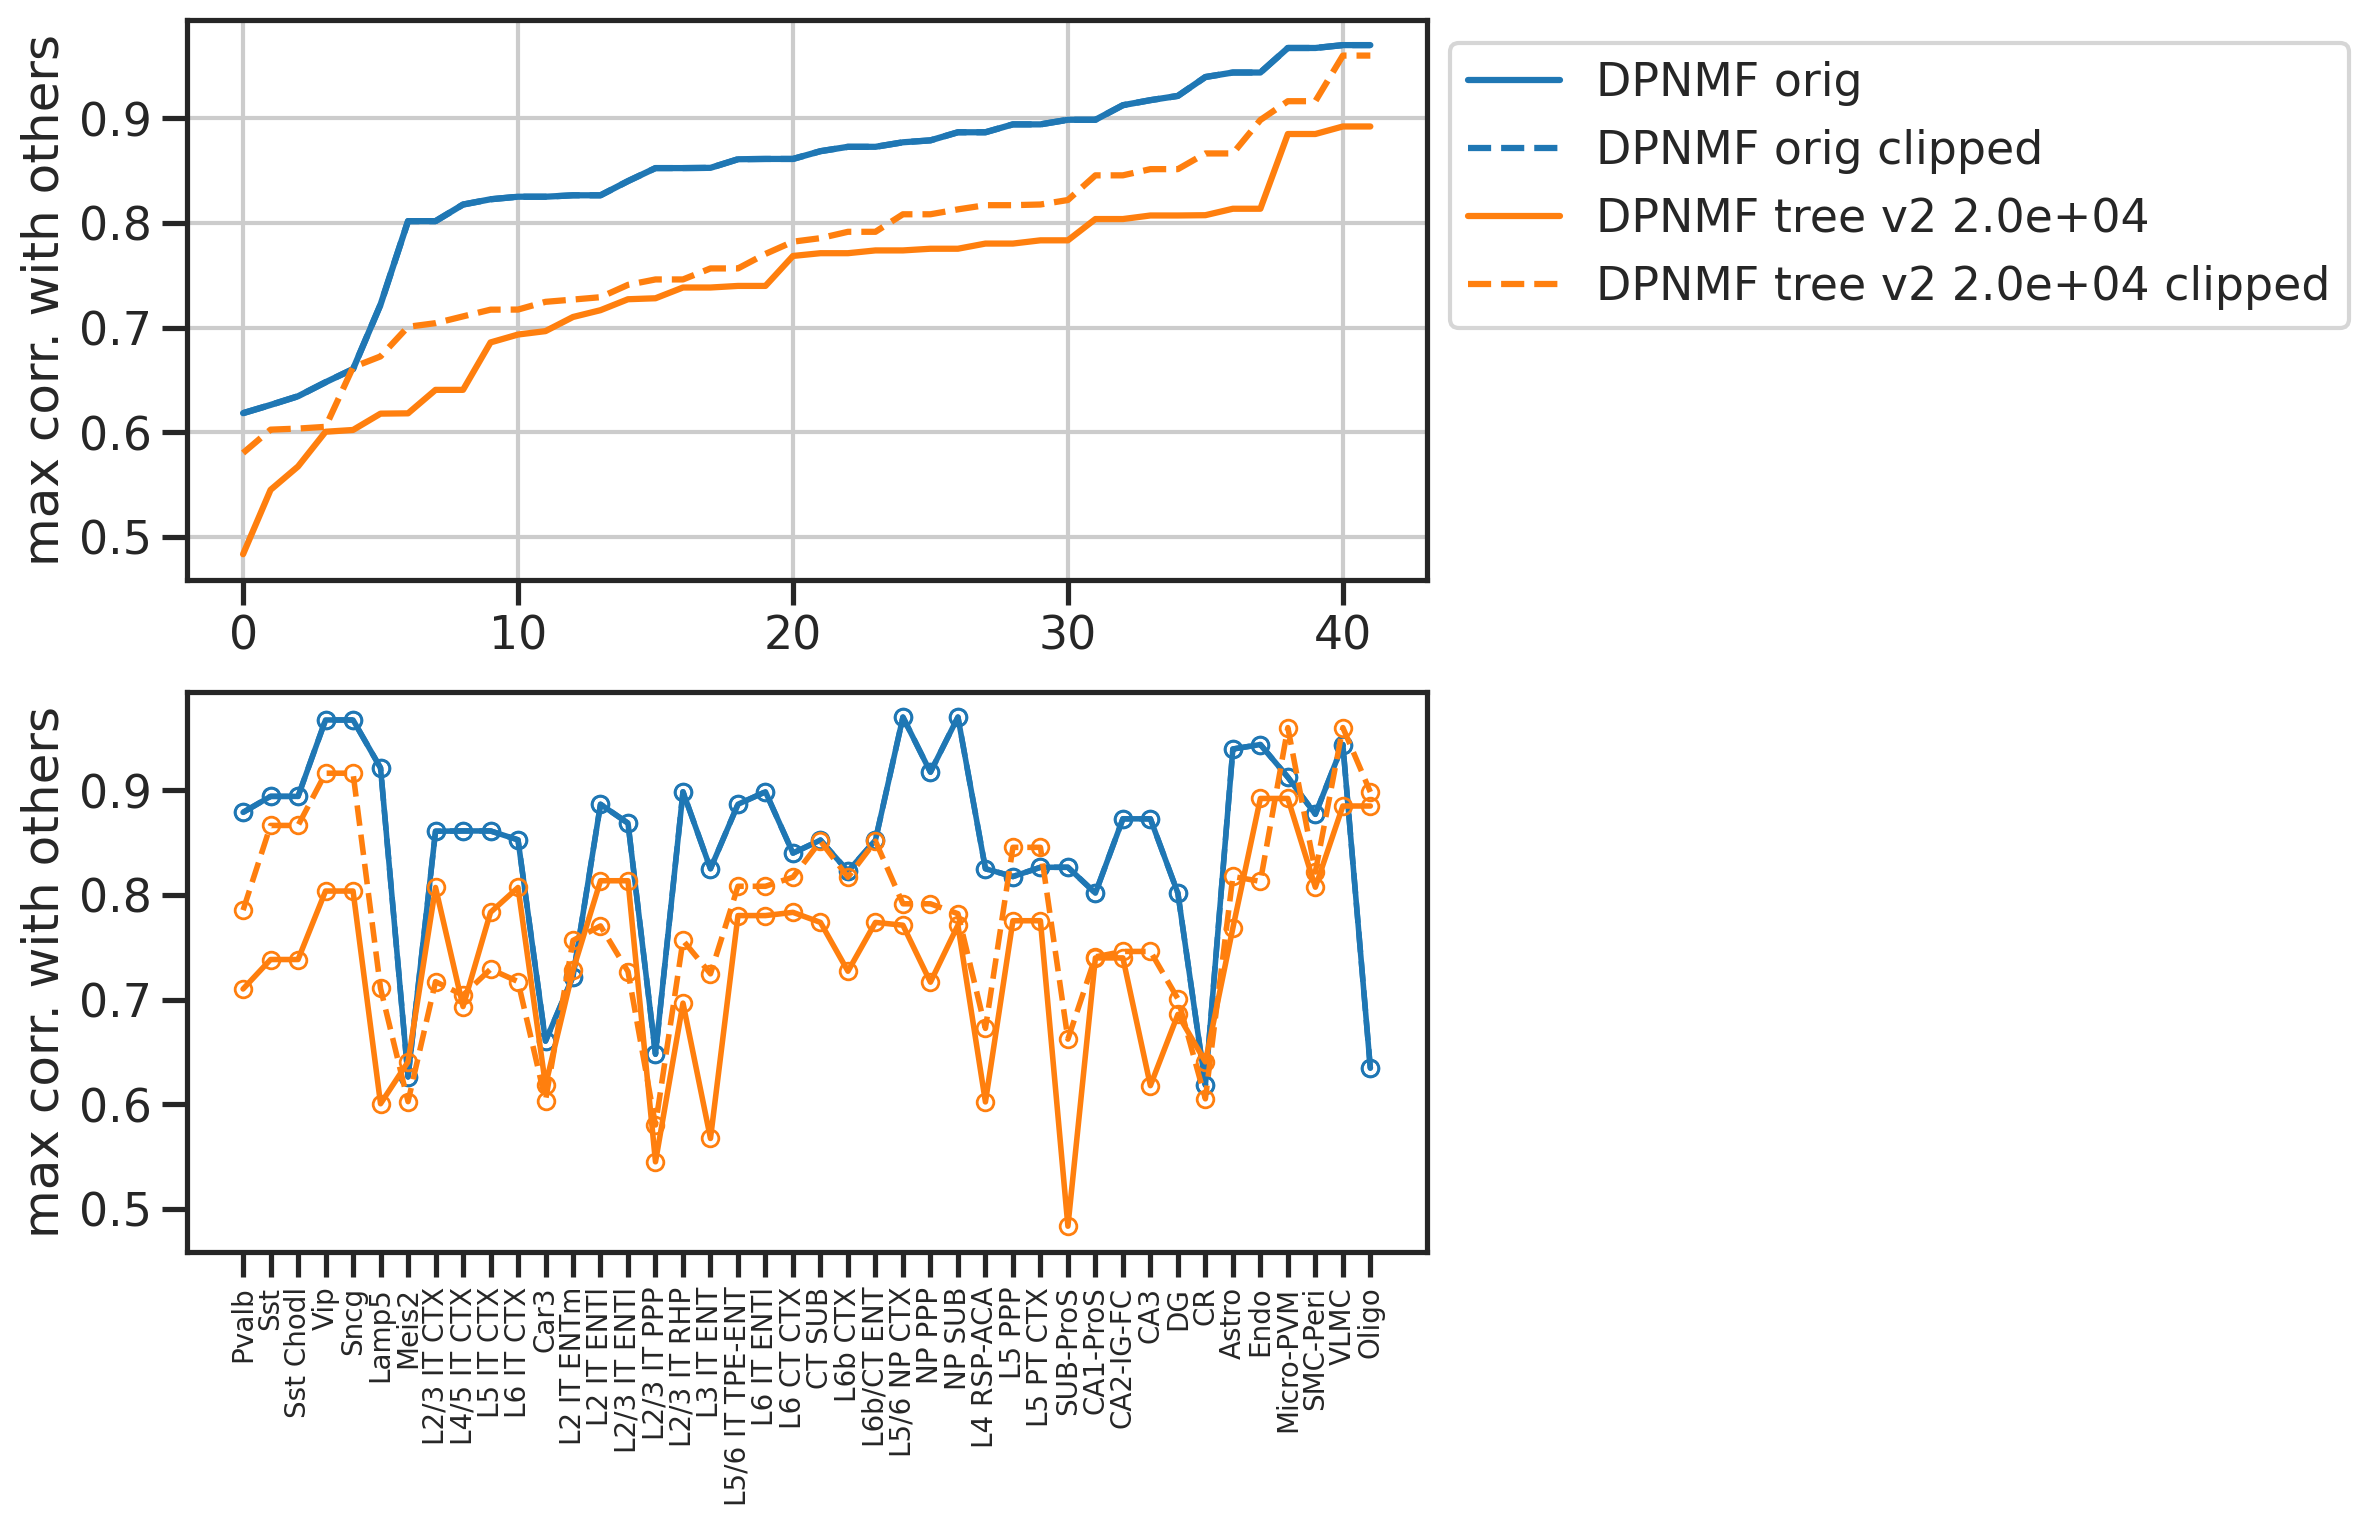

In [27]:
fig, axs = plt.subplots(2,1,figsize=(1*8,2*4))
for i, meth in enumerate(methods):
    fpmat, prjx, prjx_clsts, embx_clsts, embx_clsts_z, embx_clsts_corr, _rows, _cols, _dcols = all_res[meth] 
    corrmat = embx_clsts_corr[_rows_l3clsts,:][:,_rows_l3clsts]
    
    fpmat, prjx, prjx_clsts, embx_clsts, embx_clsts_z, embx_clsts_corr_g, _rows, _cols, _dcols = all_res_g[meth] 
    corrmat_g = embx_clsts_corr_g[_rows_l3clsts,:][:,_rows_l3clsts]
    
    # corr mat
    ax = axs[0]
    ax.plot(np.sort(np.sort(corrmat, axis=0)[-2]),   '-',  label=meth, color=colors[i])
    ax.plot(np.sort(np.sort(corrmat_g, axis=0)[-2]), '--', label=meth+' clipped', color=colors[i])
    
    ax = axs[1]
    ax.plot(np.sort(corrmat, axis=0)[-2],   '-o',  label=meth, markersize=6, linewidth=2, fillstyle='none', color=colors[i])
    ax.plot(np.sort(corrmat_g, axis=0)[-2], '--o', label=meth+' clipped', markersize=6, linewidth=2, fillstyle='none', color=colors[i])
    
    ax.set_xticks(np.arange(len(corrmat)))
    ax.set_xticklabels(l3clst_order, rotation=90, fontsize=10)
    ax.grid(False)
    
axs[0].legend(bbox_to_anchor=(1,1))
axs[0].set_ylabel('max corr. with others')
axs[1].set_ylabel('max corr. with others')
plt.show()

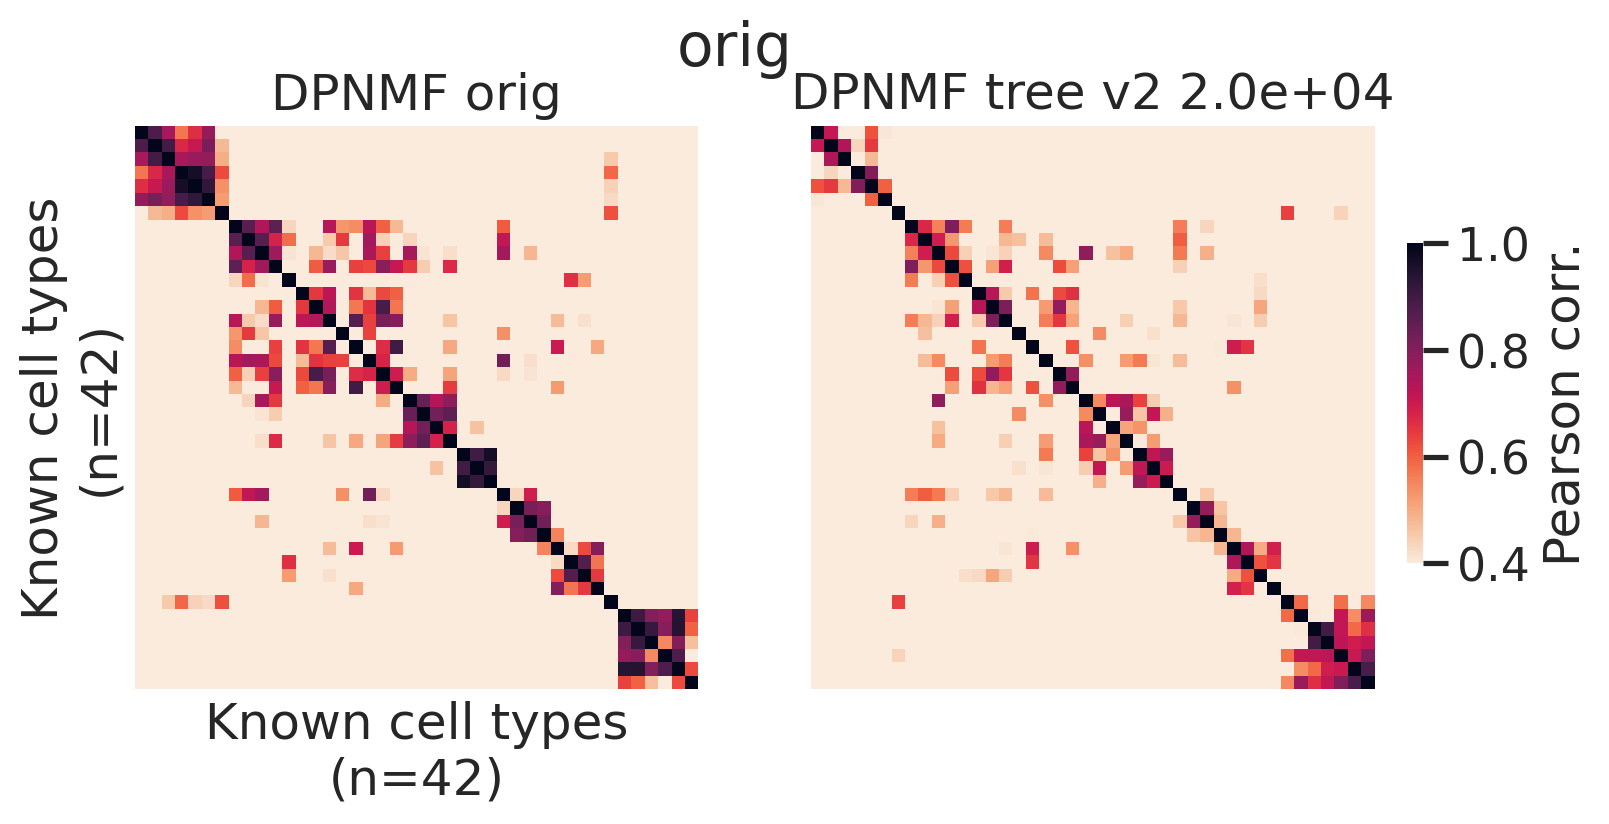

In [28]:
# DPNMF tree
n = len(methods)
nx = 2
ny = int((n+nx-1)/nx)

fig, axs = plt.subplots(ny,nx,figsize=(nx*4,ny*4))
cbar_ax = fig.add_axes([0.92, 0.3, 0.01, 0.4])
fig.suptitle('orig')
for i, meth in enumerate(methods):
    ax = axs.flat[i]
    if i == 0: 
        label = True
    else: 
        label = False
        
    fpmat, prjx, prjx_clsts, embx_clsts, embx_clsts_z, embx_clsts_corr, _rows, _cols, _dcols = all_res[meth] 
    designu.plot_heatcorr(
        # embx_clsts_corr, 
        embx_clsts_corr[_rows_l3clsts,:][:,_rows_l3clsts], 
        vmin=0.4, 
        title=meth, 
        ax=ax,
        cbar_ax=cbar_ax,
        label=label,
    )

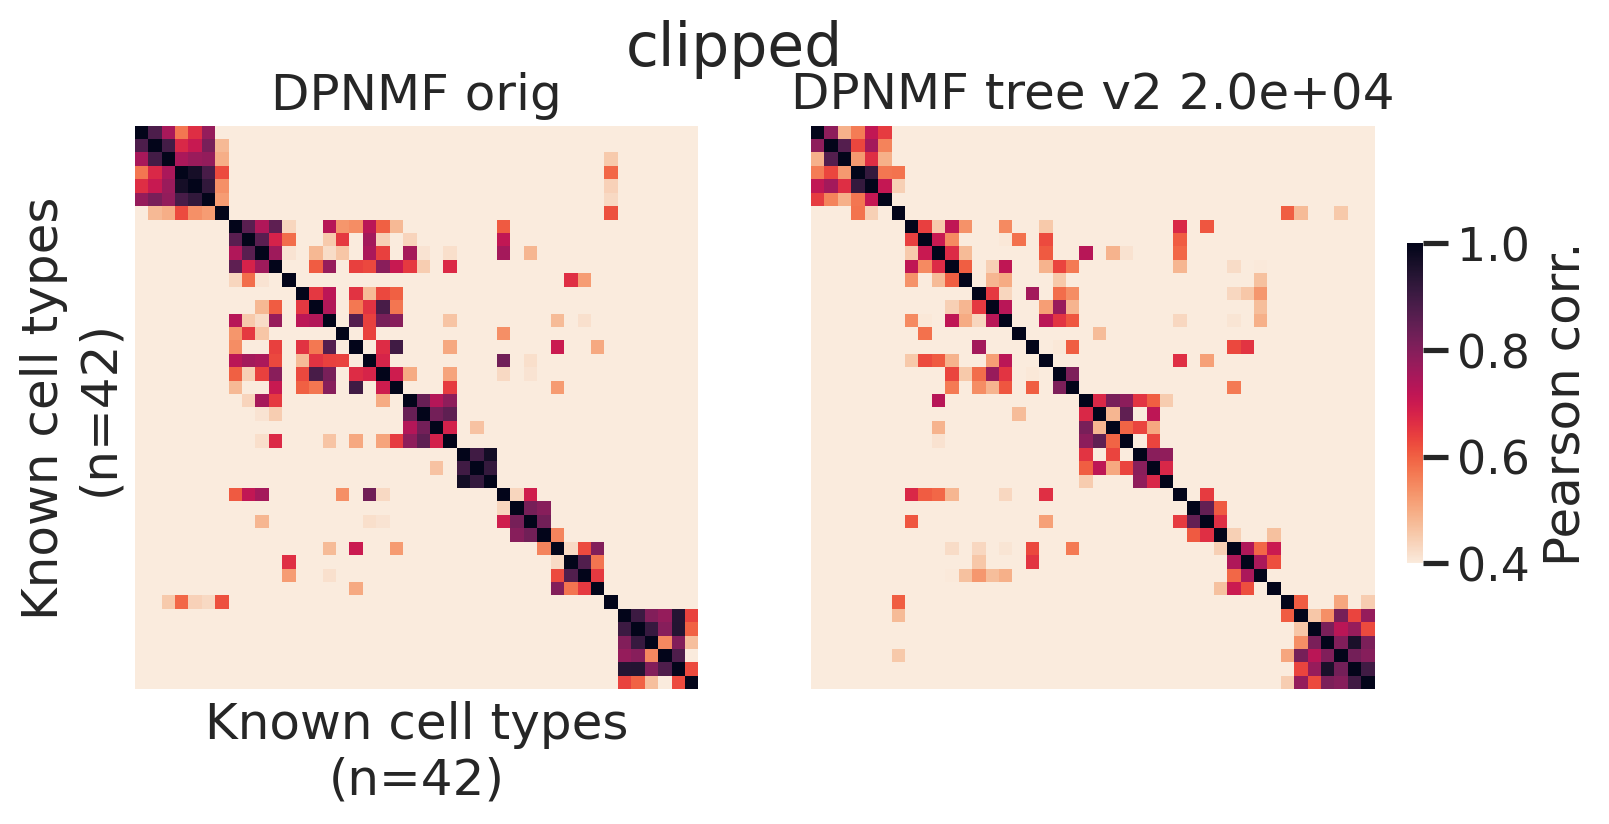

In [29]:
# DPNMF tree
n = len(methods)
nx = 2
ny = int((n+nx-1)/nx)

fig, axs = plt.subplots(ny,nx,figsize=(nx*4,ny*4))
cbar_ax = fig.add_axes([0.92, 0.3, 0.01, 0.4])
fig.suptitle('clipped')
for i, meth in enumerate(methods):
    ax = axs.flat[i]
    if i == 0: 
        label = True
    else: 
        label = False
        
    fpmat, prjx, prjx_clsts, embx_clsts, embx_clsts_z, embx_clsts_corr, _rows, _cols, _dcols = all_res_g[meth] 
    designu.plot_heatcorr(
        # embx_clsts_corr, 
        embx_clsts_corr[_rows_l3clsts,:][:,_rows_l3clsts], 
        vmin=0.4, 
        title=meth, 
        ax=ax,
        cbar_ax=cbar_ax,
        label=label,
    )

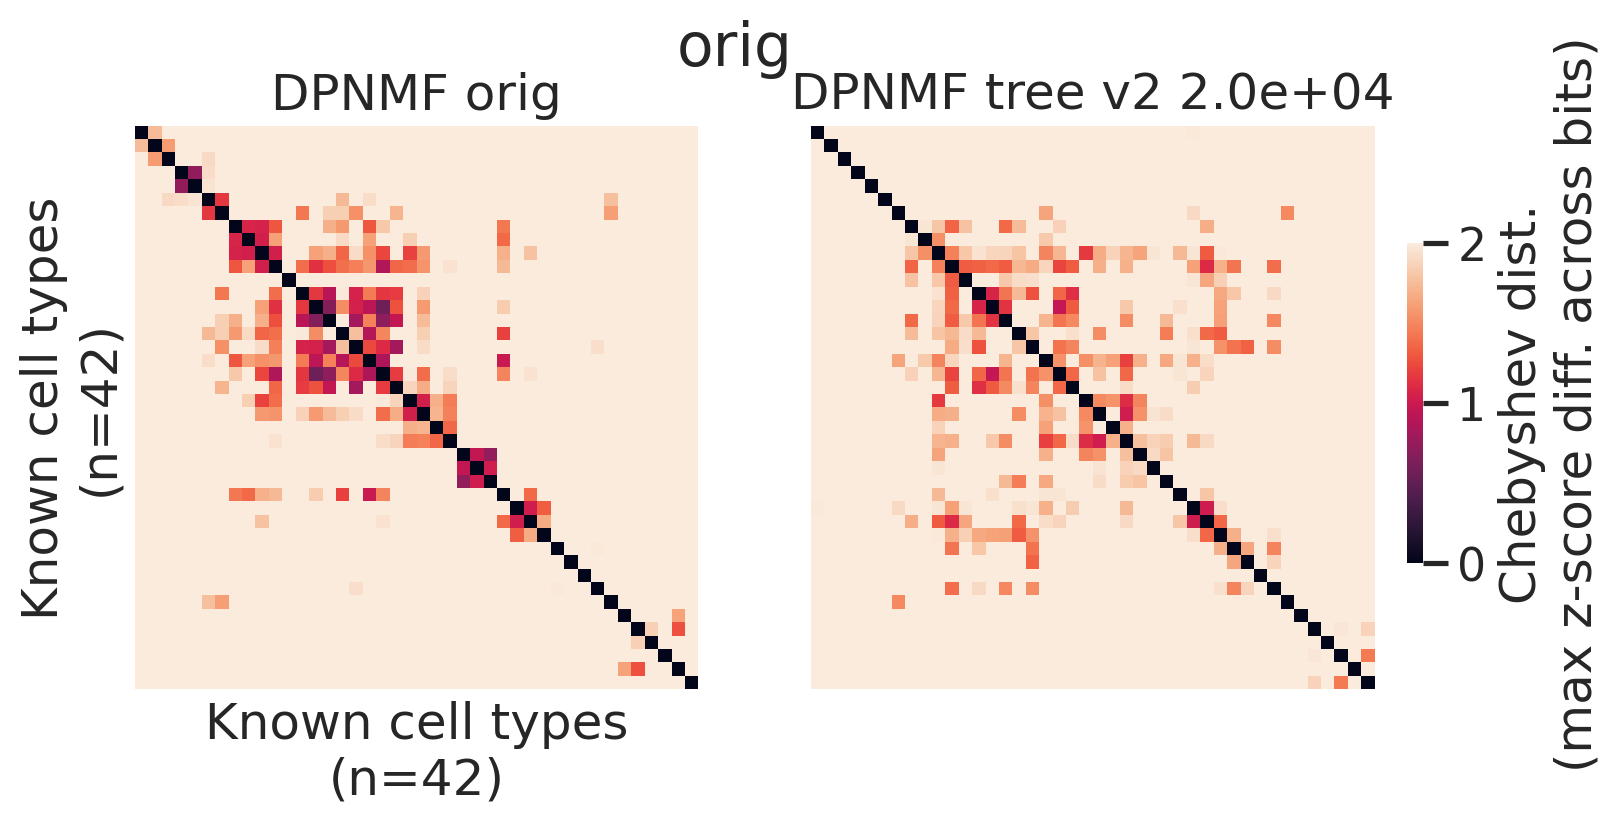

In [30]:
n = len(methods)
nx = 2
ny = int((n+nx-1)/nx)

fig, axs = plt.subplots(ny,nx,figsize=(nx*4,ny*4))
cbar_ax = fig.add_axes([0.92, 0.3, 0.01, 0.4])
fig.suptitle('orig')
for i, meth in enumerate(methods):
    ax = axs.flat[i]
    if i == 0: 
        label = True
    else: 
        label = False
        
    fpmat, prjx, prjx_clsts, embx_clsts, embx_clsts_z, embx_clsts_corr, _rows, _cols, _dcols = all_res[meth] 
    dists_cheb = pairwise_distances(embx_clsts_z, metric='chebyshev') # max across bits (Linf norm)
    distmat = dists_cheb[_rows_l3clsts,:][:,_rows_l3clsts]
    
    designu.plot_heatcorr(
        # embx_clsts_corr, 
        # embx_clsts_corr[_rows_l3clsts,:][:,_rows_l3clsts], 
        distmat,
        vmin=0, 
        vmax=2,
        title=meth, 
        ax=ax,
        cbar_ax=cbar_ax,
        label=label,
        cmap='rocket',
        metric_label='Chebyshev dist.\n(max z-score diff. across bits)')

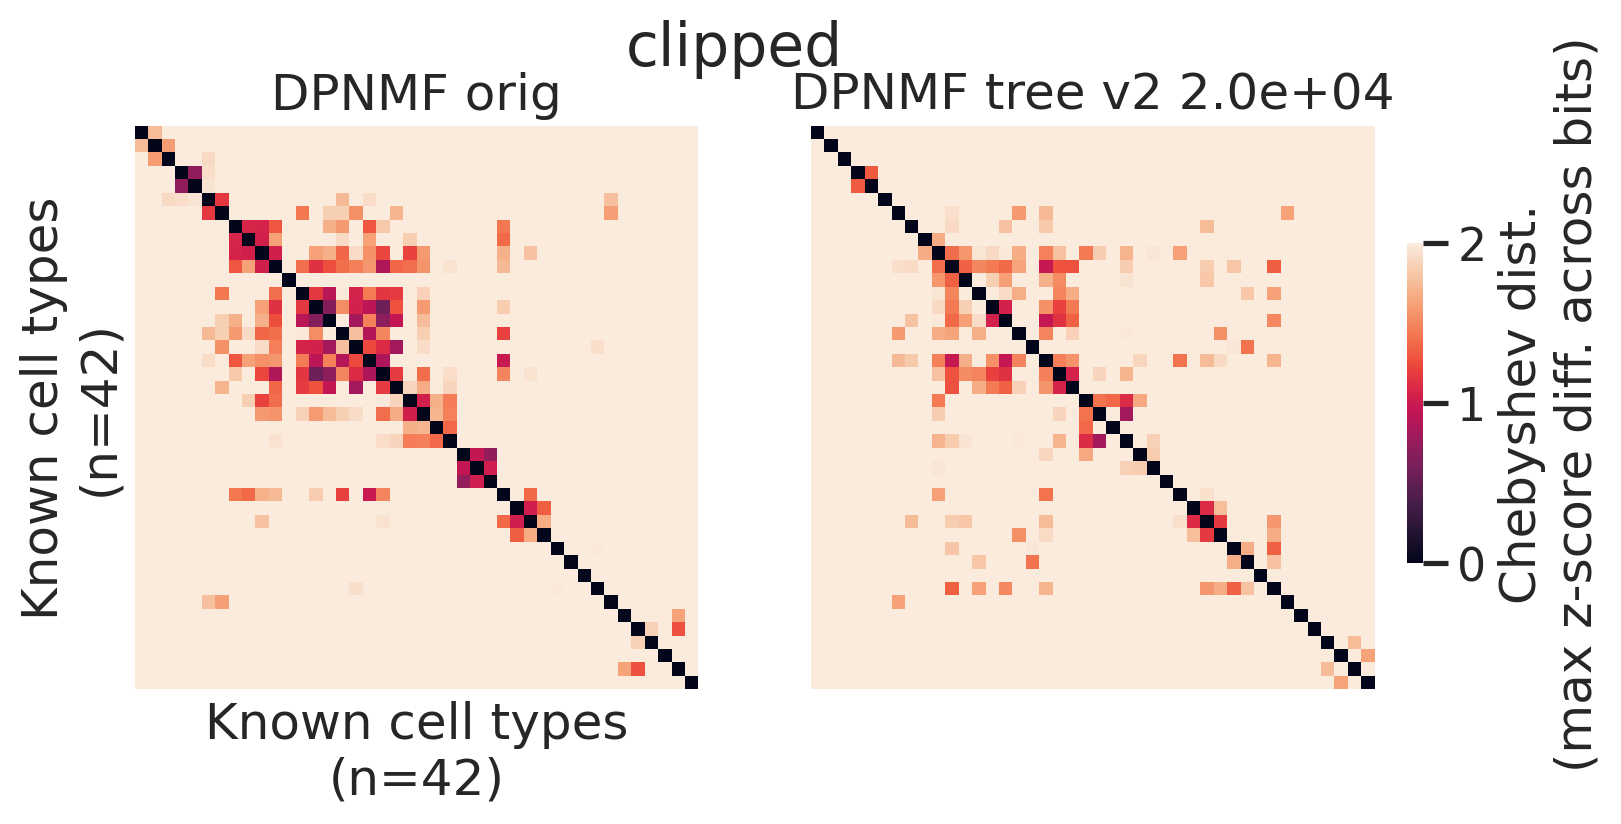

In [31]:
n = len(methods)
nx = 2
ny = int((n+nx-1)/nx)

fig, axs = plt.subplots(ny,nx,figsize=(nx*4,ny*4))
cbar_ax = fig.add_axes([0.92, 0.3, 0.01, 0.4])
fig.suptitle('clipped')
for i, meth in enumerate(methods):
    ax = axs.flat[i]
    if i == 0: 
        label = True
    else: 
        label = False
        
    fpmat, prjx, prjx_clsts, embx_clsts, embx_clsts_z, embx_clsts_corr, _rows, _cols, _dcols = all_res_g[meth] 
    dists_cheb = pairwise_distances(embx_clsts_z, metric='chebyshev') # max across bits (Linf norm)
    distmat = dists_cheb[_rows_l3clsts,:][:,_rows_l3clsts]
    
    designu.plot_heatcorr(
        # embx_clsts_corr, 
        # embx_clsts_corr[_rows_l3clsts,:][:,_rows_l3clsts], 
        distmat,
        vmin=0, 
        vmax=2,
        title=meth, 
        ax=ax,
        cbar_ax=cbar_ax,
        label=label,
        cmap='rocket',
        metric_label='Chebyshev dist.\n(max z-score diff. across bits)')

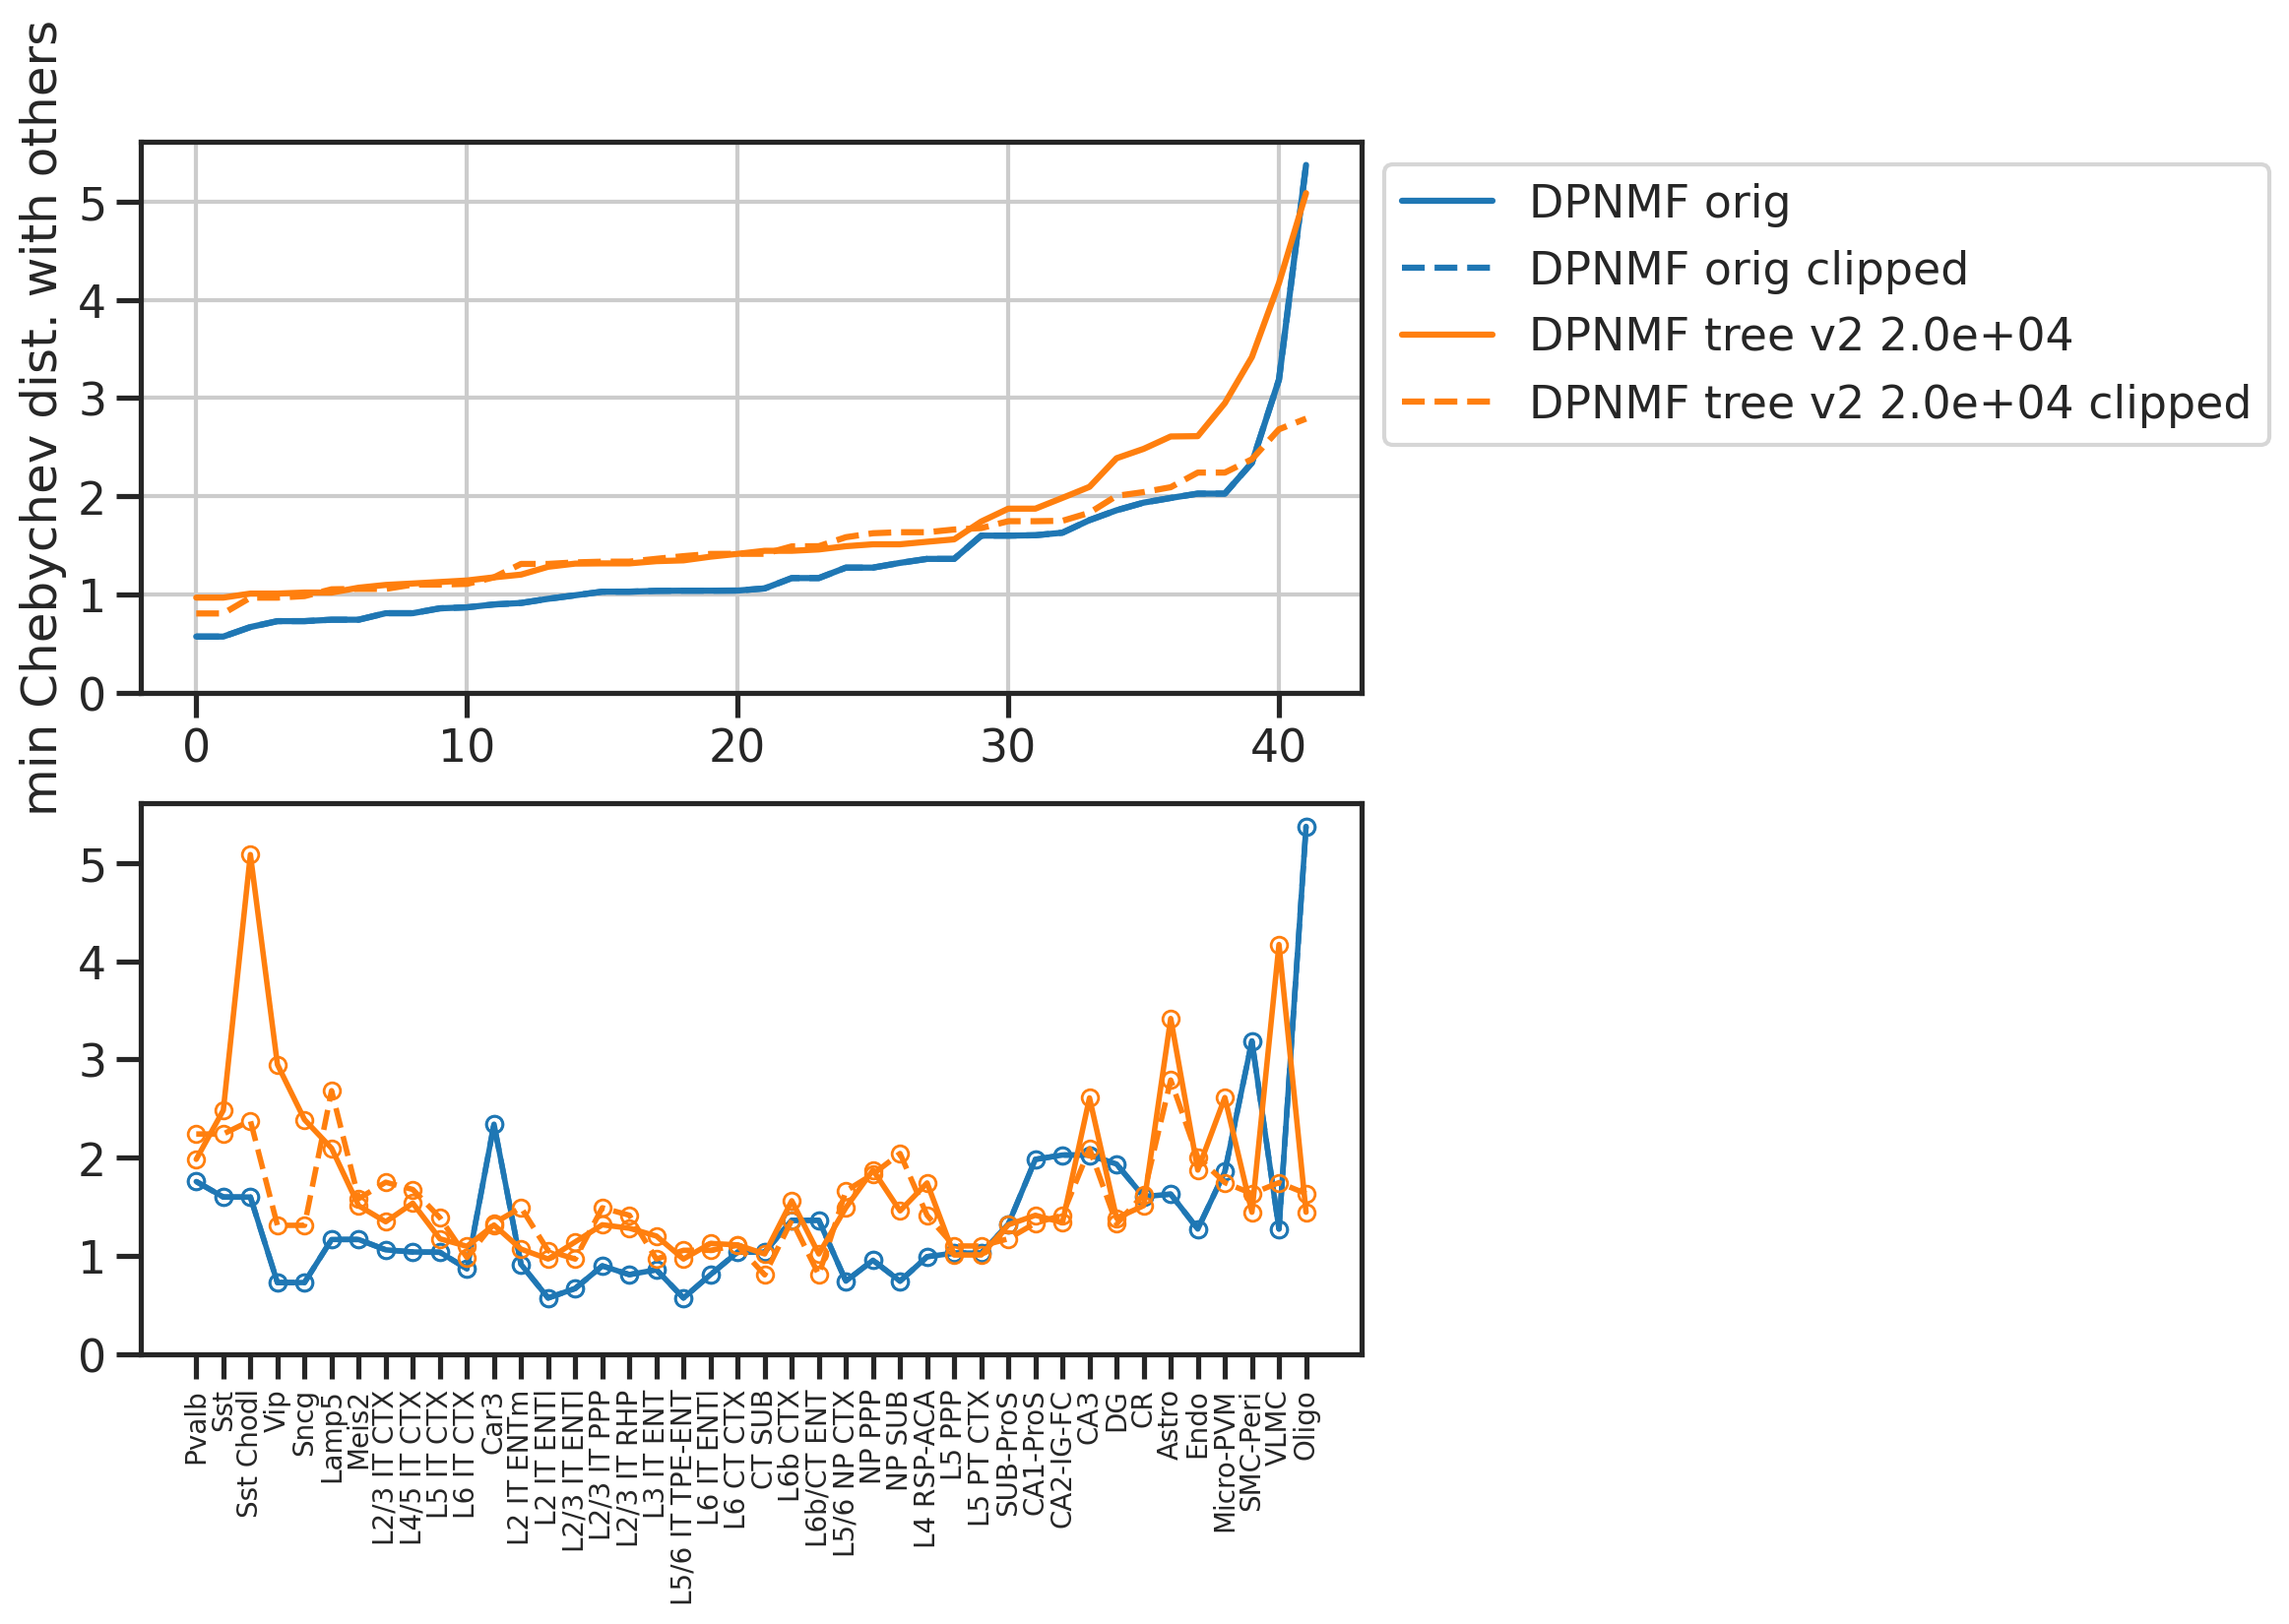

In [32]:
fig, axs = plt.subplots(2,1,figsize=(1*8,2*4))
for i, meth in enumerate(methods):
    fpmat, prjx, prjx_clsts, embx_clsts, embx_clsts_z, embx_clsts_corr, _rows, _cols, _dcols = all_res[meth] 
    dists_cheb = pairwise_distances(embx_clsts_z, metric='chebyshev') # max across bits (Linf norm)
    distmat = dists_cheb[_rows_l3clsts,:][:,_rows_l3clsts]
    
    fpmat, prjx, prjx_clsts, embx_clsts, embx_clsts_z_g, embx_clsts_corr, _rows, _cols, _dcols = all_res_g[meth] 
    dists_cheb = pairwise_distances(embx_clsts_z_g, metric='chebyshev') # max across bits (Linf norm)
    distmat_g = dists_cheb[_rows_l3clsts,:][:,_rows_l3clsts]
    
    # corr mat
    ax = axs[0]
    ax.plot(np.sort(np.sort(distmat, axis=0)[1]),   '-',  label=meth, color=colors[i])
    ax.plot(np.sort(np.sort(distmat_g, axis=0)[1]), '--', label=meth+" clipped", color=colors[i])
    
    ax = axs[1]
    ax.plot(np.sort(distmat, axis=0)[1],   '-o',  label=meth, markersize=6, linewidth=2, fillstyle='none', color=colors[i])
    ax.plot(np.sort(distmat_g, axis=0)[1], '--o', label=meth+" clipped", markersize=6, linewidth=2, fillstyle='none', color=colors[i])
    ax.set_xticks(np.arange(len(distmat)))
    ax.set_xticklabels(l3clst_order, rotation=90, fontsize=10)
    ax.grid(False)
    
axs[0].set_ylim(ymin=0)
axs[1].set_ylim(ymin=0)
axs[0].legend(bbox_to_anchor=(1,1))
axs[0].set_ylabel('min Chebychev dist. with others')
# axs[1].set_ylabel('min Chebychev dist. with others')
plt.show()